# Simple Sensor Data Visualization v2

**Purpose**: Load sensor data around sync events with individual time axes for manual sync event identification.

**Features**:
- Load 4 hours around sync start time (configurable)
- Each sensor has its own independent time axis
- Time shifts controlled by Sync_Parameters.yaml
- Preprocessing done before plotting
- Simple and focused approach

## 1. Configuration

In [1]:
# Configuration parameters
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yaml
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
import matplotlib.colors as mcolors

# ========== CONFIGURATION ==========
SUBJECT_ID = "OutSense-619"  # Change this to your subject
HOURS_AROUND_SYNC = 2  # Hours to load around sync start time (2 hours before, 2 hours after)
TARGET_FREQUENCY = 25  # Hz for resampling

# Paths
script_dir = os.path.dirname(os.path.abspath('.'))
project_root = os.path.dirname(script_dir)
sync_params_path = os.path.join(project_root, 'Sync_Parameters.yaml')
sync_events_path = os.path.join(project_root, 'Sync_Events_Times.csv')
config_path = os.path.join(project_root, 'config.yaml')
labels_path = os.path.join(project_root, 'Final_Labels_corrected.csv')

print(f"📋 Configuration:")
print(f"  Subject: {SUBJECT_ID}")
print(f"  Time window: ±{HOURS_AROUND_SYNC} hours around sync start")
print(f"  Target frequency: {TARGET_FREQUENCY} Hz")
print(f"  Project root: {project_root}")
print(f"  Labels file: {labels_path}")

# Generate a consistent set of colors for labels
def generate_label_colors(labels_list):
    """Generate consistent random colors for each unique label"""
    unique_labels = list(set(labels_list))
    random.seed(42)  # For consistent colors across runs
    colors = []
    
    for i, label in enumerate(unique_labels):
        # Use HSV color space for better color distribution
        hue = (i * 137.5) % 360  # Golden angle for good distribution
        saturation = 0.7 + (i % 3) * 0.1  # Vary saturation
        value = 0.8 + (i % 2) * 0.15  # Vary brightness
        
        # Convert HSV to RGB
        rgb = mcolors.hsv_to_rgb([hue/360, saturation, value])
        colors.append(rgb)
    
    return dict(zip(unique_labels, colors))

📋 Configuration:
  Subject: OutSense-619
  Time window: ±2 hours around sync start
  Target frequency: 25 Hz
  Project root: /scai_data3/scratch
  Labels file: /scai_data3/scratch/Final_Labels_corrected.csv


In [2]:
# ========== LABEL DRIFT CORRECTION CONFIGURATION ==========
# Label time drift correction parameters (separate from sensor drift)
LABEL_DRIFT_PARAMS = {
    "enabled": True,
    "manual_offset_seconds": 0.0,  # Manual offset in seconds (+ = shift labels forward, - = shift backward)
    "linear_drift_correction": {
        "enabled": False,
        "start_time": None,  # Will be set to sync_start_time by default
        "end_time": None,    # Will be set to sync_end_time by default
        "drift_seconds": 0.0  # Total drift over the time period
    },
    "reference_events": {
        # Define reference points for label alignment
        "enabled": False,
        "events": [
            # {"label_time": "2024-01-01 10:00:00", "true_time": "2024-01-01 10:00:05", "description": "Manual sync point"}
        ]
    }
}

print(f"📋 Label Drift Correction Configuration:")
print(f"  Manual offset: {LABEL_DRIFT_PARAMS['manual_offset_seconds']}s")
print(f"  Linear drift: {'enabled' if LABEL_DRIFT_PARAMS['linear_drift_correction']['enabled'] else 'disabled'}")
print(f"  Reference events: {'enabled' if LABEL_DRIFT_PARAMS['reference_events']['enabled'] else 'disabled'}")

📋 Label Drift Correction Configuration:
  Manual offset: 0.0s
  Linear drift: disabled
  Reference events: disabled


## 2. Load Configuration and Sync Parameters

In [3]:
# Load main configuration
with open('/scai_data3/scratch/stirnimann_r/config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

# Load sync parameters
with open('/scai_data3/scratch/stirnimann_r/Sync_Parameters.yaml', 'r') as f:
    sync_params = yaml.safe_load(f)

# Load sync events
sync_events_df = pd.read_csv('/scai_data3/scratch/stirnimann_r/Sync_Events_Times.csv')

# Load Final_Labels.csv
try:
    labels_df = pd.read_csv('/scai_data3/scratch/stirnimann_r/Final_Labels.csv')
    print(f"✅ Loaded Final_Labels.csv with {len(labels_df)} entries")
    
    # Filter labels for the current subject
    subject_labels = labels_df[labels_df['Video_File'].str.contains(SUBJECT_ID, na=False)]
    print(f"📊 Found {len(subject_labels)} labels for subject {SUBJECT_ID}")
    
    if len(subject_labels) > 0:
        # Parse the Real_Start_Time and Real_End_Time columns
        subject_labels = subject_labels.copy()
        subject_labels['Real_Start_Time'] = pd.to_datetime(subject_labels['Real_Start_Time'], errors='coerce')
        subject_labels['Real_End_Time'] = pd.to_datetime(subject_labels['Real_End_Time'], errors='coerce')
        
        # Remove any rows with invalid timestamps
        valid_labels = subject_labels.dropna(subset=['Real_Start_Time', 'Real_End_Time'])
        print(f"📅 {len(valid_labels)} labels have valid timestamps")
        
        # Generate colors for labels
        label_colors = generate_label_colors(valid_labels['Label'].tolist())
        print(f"🎨 Generated colors for {len(label_colors)} unique labels")
        
        # Show label summary
        label_summary = valid_labels['Label'].value_counts()
        print(f"\n📋 Label distribution:")
        for label, count in label_summary.head(10).items():
            print(f"  {label}: {count} instances")
        if len(label_summary) > 10:
            print(f"  ... and {len(label_summary) - 10} more labels")
    else:
        valid_labels = pd.DataFrame()
        label_colors = {}
        
except FileNotFoundError:
    print("⚠️ Final_Labels.csv not found - plots will show without labels")
    valid_labels = pd.DataFrame()
    label_colors = {}
except Exception as e:
    print(f"⚠️ Error loading Final_Labels.csv: {e}")
    valid_labels = pd.DataFrame()
    label_colors = {}

print(f"✅ Loaded configurations:")
print(f"  Main config: {len(cfg)} sections")
print(f"  Sync parameters: {len(sync_params)} subjects")
print(f"  Sync events: {len(sync_events_df)} entries")
print(f"  Labels: {len(valid_labels)} for {SUBJECT_ID}")

# Get sync start time for the subject
subject_sync = sync_events_df[sync_events_df['Subject'] == SUBJECT_ID]
if subject_sync.empty:
    raise ValueError(f"No sync events found for subject {SUBJECT_ID}")

sync_start_str = subject_sync.iloc[0]['Sync Start']
sync_end_str = subject_sync.iloc[0]['Sync End']

# Parse sync times
sync_start_time = pd.to_datetime(sync_start_str, format='%d.%m.%Y.%H.%M.%S')
sync_end_time = pd.to_datetime(sync_end_str, format='%d.%m.%Y.%H.%M.%S')

print(f"\n🎯 Sync times for {SUBJECT_ID}:")
print(f"  Sync Start: {sync_start_time}")
print(f"  Sync End: {sync_end_time}")
print(f"  Duration: {sync_end_time - sync_start_time}")

# Calculate data window to include both sync start and sync end events
# Add buffer time around both events
buffer_time = pd.Timedelta(hours=HOURS_AROUND_SYNC/2)
data_window_start = sync_start_time - buffer_time
data_window_end = sync_end_time + buffer_time

# Ensure we capture the full sync event duration plus buffer
sync_duration = sync_end_time - sync_start_time
total_window_duration = data_window_end - data_window_start

print(f"\n📊 Data window (includes both sync events + {HOURS_AROUND_SYNC/2}h buffer each side):")
print(f"  Window Start: {data_window_start} (sync start - {HOURS_AROUND_SYNC/2}h)")
print(f"  Window End: {data_window_end} (sync end + {HOURS_AROUND_SYNC/2}h)")
print(f"  Total Window Duration: {total_window_duration}")
print(f"  Sync Event Duration: {sync_duration}")
print(f"  Buffer Coverage: {buffer_time} before sync start, {buffer_time} after sync end")

# Show labels in the data window
if len(valid_labels) > 0:
    window_labels = valid_labels[
        (valid_labels['Real_Start_Time'] <= data_window_end) & 
        (valid_labels['Real_End_Time'] >= data_window_start)
    ]
    print(f"\n🏷️ Labels in data window: {len(window_labels)}")
    if len(window_labels) > 0:
        window_label_summary = window_labels['Label'].value_counts()
        for label, count in window_label_summary.head(5).items():
            print(f"  {label}: {count} instances")

✅ Loaded Final_Labels.csv with 7214 entries
📊 Found 365 labels for subject OutSense-619
📅 365 labels have valid timestamps
🎨 Generated colors for 29 unique labels

📋 Label distribution:
  self_propulsion: 155 instances
  conversation: 74 instances
  using_phone: 34 instances
  dark: 30 instances
  drinking: 13 instances
  sitting_wheelchair: 7 instances
  conversation_and_eatting: 6 instances
  bending: 6 instances
  toilet_routine: 5 instances
  preparing_meal: 4 instances
  ... and 19 more labels
✅ Loaded configurations:
  Main config: 62 sections
  Sync parameters: 16 subjects
  Sync events: 16 entries
  Labels: 365 for OutSense-619

🎯 Sync times for OutSense-619:
  Sync Start: 2023-10-03 13:24:25
  Sync End: 2023-10-05 12:54:10
  Duration: 1 days 23:29:45

📊 Data window (includes both sync events + 1.0h buffer each side):
  Window Start: 2023-10-03 12:24:25 (sync start - 1.0h)
  Window End: 2023-10-05 13:54:10 (sync end + 1.0h)
  Total Window Duration: 2 days 01:29:45
  Sync Event 

## 3. Load and Import Required Functions

In [4]:
# Import data loading functions from the original notebook/scripts
import sys
sys.path.append(project_root)

# Import necessary functions (you may need to adjust these based on your actual module structure)
try:
    from raw_data_processor import (
        select_data_loader,
        modify_modality_names,
        process_modality_duplicates,
        handle_missing_data_interpolation,
        correct_timestamp_drift
    )
    print("✅ Imported functions from raw_data_processor")
except ImportError as e:
    print(f"⚠️ Could not import from raw_data_processor: {e}")
    print("You may need to adjust the import paths or copy the required functions")
    
    # Define minimal data loader selection function
    def select_data_loader(sensor_name):
        """Simple data loader selector - you may need to implement based on your data structure"""
        def simple_csv_loader(subject_dir, sensor_name, sensor_settings):
            # This is a placeholder - implement based on your actual data structure
            csv_path = os.path.join(subject_dir, f"{sensor_name}.csv")
            if os.path.exists(csv_path):
                return pd.read_csv(csv_path)
            else:
                return pd.DataFrame()
        return simple_csv_loader
    
    def modify_modality_names(data, sensor_name):
        """Simple modality name modifier"""
        return sensor_name, data
    
    def process_modality_duplicates(data, sample_rate):
        """Simple duplicate processor"""
        return data.drop_duplicates()
    
    def handle_missing_data_interpolation(data, max_interp_gap_s=2, target_freq=50):
        """Simple interpolation"""
        return data.interpolate(method='linear', limit=int(max_interp_gap_s * target_freq))
    
    def correct_timestamp_drift(timestamp, t0, t1, drift_secs):
        """Simple drift correction"""
        if t0 <= timestamp <= t1:
            progress = (timestamp - t0) / (t1 - t0)
            return timestamp + (drift_secs * progress)
        return timestamp
    
    print("📝 Using simplified placeholder functions")

# Get raw data configuration
raw_data_parsing_config = cfg.get('raw_data_parsing_config', {})
raw_data_base_dir = os.path.join(project_root, cfg.get('raw_data_input_dir', 'data'))
subject_dir = os.path.join(raw_data_base_dir, SUBJECT_ID)

print(f"\n📂 Data paths:")
print(f"  Raw data dir: {raw_data_base_dir}")
print(f"  Subject dir: {subject_dir}")
print(f"  Available sensors: {list(raw_data_parsing_config.keys())}")

✅ Imported functions from raw_data_processor

📂 Data paths:
  Raw data dir: /scai_data2/scai_datasets/interim/scai-outsense/
  Subject dir: /scai_data2/scai_datasets/interim/scai-outsense/OutSense-619
  Available sensors: ['corsano_wrist_acc', 'cosinuss_ear_acc_x_acc_y_acc_z', 'mbient_imu_wc_accelerometer', 'mbient_imu_wc_gyroscope', 'vivalnk_vv330_acceleration', 'sensomative_bottom_logger', 'sensomative_back_logger', 'corsano_bioz_acc']


In [5]:
def apply_label_time_corrections(labels_df, drift_params, sync_start_time, sync_end_time):
    """
    Apply time drift corrections to label timestamps
    
    Parameters:
    - labels_df: DataFrame with Real_Start_Time and Real_End_Time columns
    - drift_params: Label drift correction parameters
    - sync_start_time: Reference sync start time
    - sync_end_time: Reference sync end time
    
    Returns:
    - corrected_labels_df: DataFrame with corrected timestamps
    - correction_log: Dictionary with applied corrections
    """
    if labels_df.empty:
        return labels_df, {}
    
    corrected_labels = labels_df.copy()
    correction_log = {
        "manual_offset_applied": 0.0,
        "linear_drift_applied": False,
        "reference_events_applied": 0,
        "total_labels_corrected": len(labels_df)
    }
    
    print(f"🔧 Applying label time corrections to {len(labels_df)} labels...")
    
    # 1. Apply manual offset
    if drift_params.get("enabled", False):
        manual_offset = drift_params.get("manual_offset_seconds", 0.0)
        if manual_offset != 0.0:
            offset_timedelta = pd.Timedelta(seconds=manual_offset)
            corrected_labels['Real_Start_Time'] += offset_timedelta
            corrected_labels['Real_End_Time'] += offset_timedelta
            correction_log["manual_offset_applied"] = manual_offset
            print(f"  ⏱️ Applied manual offset: {manual_offset}s")
    
    # 2. Apply linear drift correction
    linear_drift = drift_params.get("linear_drift_correction", {})
    if linear_drift.get("enabled", False):
        start_time = pd.to_datetime(linear_drift.get("start_time")) if linear_drift.get("start_time") else sync_start_time
        end_time = pd.to_datetime(linear_drift.get("end_time")) if linear_drift.get("end_time") else sync_end_time
        drift_seconds = linear_drift.get("drift_seconds", 0.0)
        
        if drift_seconds != 0.0 and start_time < end_time:
            duration_seconds = (end_time - start_time).total_seconds()
            
            def apply_linear_drift(timestamp):
                if pd.isna(timestamp):
                    return timestamp
                
                if start_time <= timestamp <= end_time:
                    # Calculate progress through the drift period (0 to 1)
                    progress = (timestamp - start_time).total_seconds() / duration_seconds
                    # Apply proportional drift correction
                    drift_correction = pd.Timedelta(seconds=drift_seconds * progress)
                    return timestamp + drift_correction
                return timestamp
            
            corrected_labels['Real_Start_Time'] = corrected_labels['Real_Start_Time'].apply(apply_linear_drift)
            corrected_labels['Real_End_Time'] = corrected_labels['Real_End_Time'].apply(apply_linear_drift)
            correction_log["linear_drift_applied"] = True
            print(f"  📐 Applied linear drift correction: {drift_seconds}s over {duration_seconds/60:.1f} minutes")
    
    # 3. Apply reference event corrections
    ref_events = drift_params.get("reference_events", {})
    if ref_events.get("enabled", False) and ref_events.get("events"):
        events_applied = 0
        for event in ref_events["events"]:
            label_time = pd.to_datetime(event["label_time"])
            true_time = pd.to_datetime(event["true_time"])
            correction = true_time - label_time
            
            # Apply correction to labels near this reference point
            # (You could implement more sophisticated interpolation between reference points)
            tolerance = pd.Timedelta(minutes=30)  # Apply to labels within 30 minutes
            mask = (
                (corrected_labels['Real_Start_Time'] >= label_time - tolerance) &
                (corrected_labels['Real_Start_Time'] <= label_time + tolerance)
            )
            
            if mask.any():
                corrected_labels.loc[mask, 'Real_Start_Time'] += correction
                corrected_labels.loc[mask, 'Real_End_Time'] += correction
                events_applied += mask.sum()
                print(f"  🎯 Applied reference event correction: {correction} to {mask.sum()} labels")
        
        correction_log["reference_events_applied"] = events_applied
    
    return corrected_labels, correction_log

def create_label_drift_controls():
    """Create interactive controls for label drift correction"""
    
    # Manual offset control
    manual_offset_slider = widgets.FloatSlider(
        value=LABEL_DRIFT_PARAMS["manual_offset_seconds"],
        min=-300.0,  # -5 minutes
        max=300.0,   # +5 minutes
        step=0.1,
        description='Manual Offset (s):',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )
    
    # Linear drift controls
    enable_linear_drift = widgets.Checkbox(
        value=LABEL_DRIFT_PARAMS["linear_drift_correction"]["enabled"],
        description='Enable Linear Drift Correction',
        style={'description_width': 'initial'}
    )
    
    linear_drift_slider = widgets.FloatSlider(
        value=LABEL_DRIFT_PARAMS["linear_drift_correction"]["drift_seconds"],
        min=-60.0,   # -1 minute total drift
        max=60.0,    # +1 minute total drift
        step=0.1,
        description='Linear Drift (s):',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )
    
    # Quick preset buttons
    reset_corrections = widgets.Button(
        description='🔄 Reset All Corrections',
        button_style='warning',
        layout=widgets.Layout(width='200px')
    )
    
    apply_corrections = widgets.Button(
        description='✅ Apply & Replot',
        button_style='success',
        layout=widgets.Layout(width='200px')
    )
    
    # Drift analysis display
    drift_analysis_output = widgets.Output()
    
    return {
        'manual_offset_slider': manual_offset_slider,
        'enable_linear_drift': enable_linear_drift,
        'linear_drift_slider': linear_drift_slider,
        'reset_corrections': reset_corrections,
        'apply_corrections': apply_corrections,
        'drift_analysis_output': drift_analysis_output
    }

print("✅ Label drift correction functions defined")

✅ Label drift correction functions defined


## 4. Load and Process Sensor Data

In [6]:
# Load and process each sensor with time shifts from Sync_Parameters.yaml
print(f"\n=== LOADING SENSOR DATA ===")
print(f"Processing sensors for subject: {SUBJECT_ID}")
print(f"Time window: {data_window_start} to {data_window_end}")

processed_sensors = {}
subject_correction_params = sync_params.get(SUBJECT_ID, {})

for sensor_name, sensor_settings in raw_data_parsing_config.items():
    print(f"\n--- Processing sensor: {sensor_name} ---")
    
    try:
        # Load raw sensor data
        loader = select_data_loader(sensor_name)
        sensor_data_raw = loader(subject_dir, sensor_name, sensor_settings)
        
        if sensor_data_raw.empty or 'time' not in sensor_data_raw.columns:
            print(f"❌ No data loaded for {sensor_name}")
            continue
        
        print(f"📊 Loaded {len(sensor_data_raw)} raw samples")
        
        # Get time correction parameters for this sensor
        sensor_corr_params = subject_correction_params.get(sensor_name, {'unit': 's'})
        time_unit = sensor_corr_params.get('unit', 's')
        shift_val = sensor_corr_params.get('shift', 0)
        
        # Apply time corrections
        time_col_num = sensor_data_raw['time'].astype(float)
        
        # Convert to seconds if needed
        if time_unit == 'ms':
            time_col_num = time_col_num / 1000.0
        
        # Apply shift correction
        if shift_val != 0:
            time_col_num = time_col_num + shift_val
            print(f"⏱️ Applied time shift: {shift_val}s")
        
        # Apply drift correction if available
        drift_params = sensor_corr_params.get('drift')
        if drift_params and all(k in drift_params for k in ['t0', 't1', 'drift_secs']):
            t0_ts = pd.Timestamp(drift_params['t0'])
            t1_ts = pd.Timestamp(drift_params['t1'])
            if not pd.isna(t0_ts) and not pd.isna(t1_ts):
                t0, t1 = t0_ts.timestamp(), t1_ts.timestamp()
                drift = drift_params['drift_secs']
                time_col_num = time_col_num.apply(correct_timestamp_drift, args=(t0, t1, drift))
                print(f"📐 Applied drift correction: {drift}s over {t1-t0:.1f}s interval")
        
        # Convert to datetime
        corrected_timestamps = pd.to_datetime(time_col_num, unit='s', errors='coerce')
        sensor_data_corrected = sensor_data_raw.drop(columns=['time']).copy()
        sensor_data_corrected['time'] = corrected_timestamps
        sensor_data_corrected.dropna(subset=['time'], inplace=True)
        
        if sensor_data_corrected.empty:
            print(f"❌ No valid data after time correction for {sensor_name}")
            continue
        
        # Filter to data window
        original_count = len(sensor_data_corrected)
        time_mask = (sensor_data_corrected['time'] >= data_window_start) & (sensor_data_corrected['time'] <= data_window_end)
        sensor_data_filtered = sensor_data_corrected[time_mask].copy()
        
        filtered_count = len(sensor_data_filtered)
        retention_pct = (filtered_count / original_count * 100) if original_count > 0 else 0
        print(f"🔍 Filtered from {original_count} to {filtered_count} samples ({retention_pct:.1f}% retained)")
        
        if sensor_data_filtered.empty:
            print(f"❌ No data in time window for {sensor_name}")
            continue
        
        # Set time as index
        sensor_data_filtered.set_index('time', inplace=True)
        sensor_data_filtered.sort_index(inplace=True)
        
        # Apply basic preprocessing
        sample_rate = sensor_settings.get('sample_rate', TARGET_FREQUENCY)
        processed_data = process_modality_duplicates(sensor_data_filtered, sample_rate)
        processed_data = handle_missing_data_interpolation(processed_data, max_interp_gap_s=2, target_freq=TARGET_FREQUENCY)
        
        # Apply column renaming
        new_name, processed_data = modify_modality_names(processed_data, sensor_name)
        
        if processed_data.empty:
            print(f"❌ No data after preprocessing for {sensor_name}")
            continue
        
        print(f"✅ Final shape: {processed_data.shape}")
        print(f"✅ Time range: {processed_data.index.min()} to {processed_data.index.max()}")
        
        processed_sensors[new_name] = processed_data
        
    except Exception as e:
        print(f"❌ Error processing sensor {sensor_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n📈 Successfully processed {len(processed_sensors)} sensors:")
for sensor_name, data in processed_sensors.items():
    duration = data.index.max() - data.index.min()
    print(f"  📊 {sensor_name}: {len(data)} samples, duration {duration}")

if not processed_sensors:
    raise ValueError("No sensor data was successfully processed!")


=== LOADING SENSOR DATA ===
Processing sensors for subject: OutSense-619
Time window: 2023-10-03 12:24:25 to 2023-10-05 13:54:10

--- Processing sensor: corsano_wrist_acc ---
📊 Loaded 2416320 raw samples
⏱️ Applied time shift: 7199s
📊 Loaded 2416320 raw samples
⏱️ Applied time shift: 7199s
🔍 Filtered from 2416320 to 2416320 samples (100.0% retained)
🔍 Filtered from 2416320 to 2416320 samples (100.0% retained)
✅ Final shape: (2416320, 3)
✅ Time range: 2023-10-03 12:50:25 to 2023-10-05 13:10:33.967999935

--- Processing sensor: cosinuss_ear_acc_x_acc_y_acc_z ---
✅ Final shape: (2416320, 3)
✅ Time range: 2023-10-03 12:50:25 to 2023-10-05 13:10:33.967999935

--- Processing sensor: cosinuss_ear_acc_x_acc_y_acc_z ---
📊 Loaded 3839064 raw samples
📊 Loaded 3839064 raw samples
🔍 Filtered from 3839064 to 3587088 samples (93.4% retained)
🔍 Filtered from 3839064 to 3587088 samples (93.4% retained)
✅ Final shape: (3587088, 3)
✅ Time range: 2023-10-03 12:48:30.302000046 to 2023-10-04 17:51:39.63299

## 5. Interactive Plotting with Independent Time Axes

In [7]:
# Create interactive plotting tool with independent time axes AND label drift correction
print("=== INTERACTIVE SENSOR VISUALIZATION WITH LABEL DRIFT CORRECTION ===")
print("🎯 Each sensor has its own independent time axis")
print("🔍 Perfect for manual sync event identification")
print("🏷️ Labels from Final_Labels.csv with real-time drift correction")

# Create controls
sensor_names = list(processed_sensors.keys())

# Sensor selection (existing)
sensor_selection = widgets.SelectMultiple(
    options=sensor_names,
    value=sensor_names[:3] if len(sensor_names) >= 3 else sensor_names,
    description='Select Sensors:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(height='200px', width='300px')
)

# Label display controls (existing)
show_labels = widgets.Checkbox(
    value=True,
    description='Show Labels',
    style={'description_width': 'initial'}
)

label_alpha = widgets.FloatSlider(
    value=0.3,
    min=0.1,
    max=0.8,
    step=0.1,
    description='Label Alpha:',
    style={'description_width': 'initial'}
)

# Create label drift correction controls
label_drift_controls = create_label_drift_controls()

# Store corrected labels globally for reuse
corrected_labels_global = valid_labels.copy() if len(valid_labels) > 0 else pd.DataFrame()
current_correction_log = {}

def update_label_corrections():
    """Update label corrections based on current control values"""
    global corrected_labels_global, current_correction_log
    
    if len(valid_labels) == 0:
        return
    
    # Get current drift parameters from controls
    current_drift_params = {
        "enabled": True,
        "manual_offset_seconds": label_drift_controls['manual_offset_slider'].value,
        "linear_drift_correction": {
            "enabled": label_drift_controls['enable_linear_drift'].value,
            "start_time": sync_start_time,
            "end_time": sync_end_time,
            "drift_seconds": label_drift_controls['linear_drift_slider'].value
        }
    }
    
    # Apply corrections
    corrected_labels_global, current_correction_log = apply_label_time_corrections(
        valid_labels, current_drift_params, sync_start_time, sync_end_time
    )
    
    # Update drift analysis display
    with label_drift_controls['drift_analysis_output']:
        clear_output(wait=True)
        print("📊 Current Label Drift Corrections:")
        print(f"  Manual Offset: {current_correction_log.get('manual_offset_applied', 0)}s")
        if current_correction_log.get('linear_drift_applied', False):
            print(f"  Linear Drift: {current_drift_params['linear_drift_correction']['drift_seconds']}s")
        print(f"  Labels Affected: {current_correction_log.get('total_labels_corrected', 0)}")
        
        if len(corrected_labels_global) > 0:
            original_time_range = f"{valid_labels['Real_Start_Time'].min()} to {valid_labels['Real_End_Time'].max()}"
            corrected_time_range = f"{corrected_labels_global['Real_Start_Time'].min()} to {corrected_labels_global['Real_End_Time'].max()}"
            print(f"\n⏱️ Time Range Comparison:")
            print(f"  Original:  {original_time_range}")
            print(f"  Corrected: {corrected_time_range}")

# Label filter (updated to use corrected labels)
if len(valid_labels) > 0:
    unique_labels_in_window = sorted(valid_labels['Label'].unique())
    label_filter = widgets.SelectMultiple(
        options=unique_labels_in_window,
        value=unique_labels_in_window[:10] if len(unique_labels_in_window) > 10 else unique_labels_in_window,
        description='Show Labels:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(height='150px', width='300px')
    )
else:
    label_filter = widgets.SelectMultiple(
        options=[],
        value=[],
        description='Show Labels:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(height='150px', width='300px')
    )

# Time window controls
center_time_text = widgets.Text(
    value=sync_start_time.strftime('%Y-%m-%d %H:%M:%S'),
    description='Center Time:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

window_minutes = widgets.IntSlider(
    value=60,  # 1 hour window
    min=1,
    max=240,  # 4 hours max
    step=1,
    description='Window (min):',
    style={'description_width': 'initial'}
)

# Time navigation buttons (10 minutes forward/backward)
nav_backward_10min = widgets.Button(description='⏪ -10min', button_style='', 
                                   layout=widgets.Layout(width='100px'))
nav_forward_10min = widgets.Button(description='⏩ +10min', button_style='', 
                                  layout=widgets.Layout(width='100px'))

# Quick jump buttons
jump_sync_start = widgets.Button(description='🎯 Jump to Sync Start', button_style='success')
jump_sync_end = widgets.Button(description='🎯 Jump to Sync End', button_style='warning')
jump_data_start = widgets.Button(description='📊 Jump to Data Start', button_style='info')
jump_data_end = widgets.Button(description='📊 Jump to Data End', button_style='info')

# Plot button
plot_button = widgets.Button(description='📈 Plot Sensors', button_style='primary', layout=widgets.Layout(width='150px'))

# Auto-plot checkbox
auto_plot = widgets.Checkbox(
    value=True,
    description='Auto-plot on navigation',
    style={'description_width': 'initial'}
)

# Output area
plot_output = widgets.Output()

def get_center_time():
    """Get center time from text widget"""
    try:
        return pd.to_datetime(center_time_text.value)
    except:
        return sync_start_time

def update_center_time(new_time):
    """Update center time text widget"""
    center_time_text.value = new_time.strftime('%Y-%m-%d %H:%M:%S')

def plot_sensors_with_drift_correction(btn):
    """Plot selected sensors with corrected label overlays"""
    
    # Update label corrections first
    update_label_corrections()
    
    with plot_output:
        clear_output(wait=True)
        
        try:
            selected_sensors = list(sensor_selection.value)
            if not selected_sensors:
                print("❌ Please select at least one sensor")
                return
            
            center_time = get_center_time()
            window_mins = window_minutes.value
            
            # Calculate time window
            half_window = pd.Timedelta(minutes=window_mins/2)
            plot_start = center_time - half_window
            plot_end = center_time + half_window
            
            print(f"📊 Plotting {len(selected_sensors)} sensors with corrected labels")
            print(f"⏱️ Time window: {plot_start} to {plot_end} ({window_mins} minutes)")
            print(f"🎯 Center time: {center_time}")
            
            # Use corrected labels for plotting
            if show_labels.value and len(corrected_labels_global) > 0:
                selected_label_types = list(label_filter.value)
                plot_labels = corrected_labels_global[
                    (corrected_labels_global['Real_Start_Time'] <= plot_end) & 
                    (corrected_labels_global['Real_End_Time'] >= plot_start) &
                    (corrected_labels_global['Label'].isin(selected_label_types))
                ]
                print(f"🏷️ Showing {len(plot_labels)} corrected labels in window")
                
                # Show correction info
                if current_correction_log.get('manual_offset_applied', 0) != 0:
                    print(f"🔧 Manual offset applied: {current_correction_log['manual_offset_applied']}s")
                if current_correction_log.get('linear_drift_applied', False):
                    print(f"🔧 Linear drift correction applied")
            else:
                plot_labels = pd.DataFrame()
            
            # Create plot
            fig, axes = plt.subplots(len(selected_sensors), 1, 
                                   figsize=(16, 3*len(selected_sensors)), 
                                   sharex=False)
            if len(selected_sensors) == 1:
                axes = [axes]
            
            for i, sensor_name in enumerate(selected_sensors):
                ax = axes[i]
                
                if sensor_name not in processed_sensors:
                    ax.text(0.5, 0.5, f'No data for {sensor_name}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{sensor_name} - No Data')
                    continue
                
                sensor_data = processed_sensors[sensor_name]
                mask = (sensor_data.index >= plot_start) & (sensor_data.index <= plot_end)
                plot_data = sensor_data[mask]
                
                if plot_data.empty:
                    ax.text(0.5, 0.5, f'No data in time window for {sensor_name}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{sensor_name} - No Data in Window')
                    continue
                
                # Plot sensor data
                numeric_cols = plot_data.select_dtypes(include=[np.number]).columns
                for col in numeric_cols:
                    ax.plot(plot_data.index, plot_data[col], 
                           label=col, alpha=0.7, linewidth=1)
                
                # Add CORRECTED label shading
                if show_labels.value and len(plot_labels) > 0:
                    y_min, y_max = ax.get_ylim() if len(numeric_cols) > 0 else (0, 1)
                    
                    label_count = {}
                    for _, label_row in plot_labels.iterrows():
                        label_name = label_row['Label']
                        start_time = max(label_row['Real_Start_Time'], plot_start)
                        end_time = min(label_row['Real_End_Time'], plot_end)
                        
                        if start_time < end_time:
                            color = label_colors.get(label_name, 'gray')
                            
                            if label_name not in label_count:
                                label_count[label_name] = 0
                            label_count[label_name] += 1
                            
                            # Add shaded region with corrected times
                            ax.axvspan(start_time, end_time, 
                                     alpha=label_alpha.value, 
                                     color=color,
                                     label=f'{label_name} (corrected)' if label_count[label_name] == 1 else "")
                            
                            # Add label text for longer labels
                            duration = end_time - start_time
                            if duration > pd.Timedelta(minutes=2):
                                mid_time = start_time + (end_time - start_time) / 2
                                if len(numeric_cols) > 0:
                                    y_pos = y_max - (y_max - y_min) * 0.05
                                else:
                                    y_pos = 0.5
                                
                                ax.text(mid_time, y_pos, f'{label_name}✓', 
                                       ha='center', va='top', rotation=0,
                                       fontsize=8, alpha=0.8,
                                       bbox=dict(boxstyle='round,pad=0.2', 
                                               facecolor='lightgreen', alpha=0.7))
                
                # Add sync events and other markers
                if plot_start <= sync_start_time <= plot_end:
                    ax.axvline(sync_start_time, color='red', linestyle='--', 
                             linewidth=2, alpha=0.8, label='🎯 Sync Start')
                
                if plot_start <= sync_end_time <= plot_end:
                    ax.axvline(sync_end_time, color='darkred', linestyle='--', 
                             linewidth=2, alpha=0.8, label='🎯 Sync End')
                
                ax.axvline(center_time, color='green', linestyle=':', 
                         linewidth=1, alpha=0.6, label='Center')
                
                # Formatting
                title_text = f'{sensor_name} ({len(numeric_cols)} channels)'
                if show_labels.value and len(plot_labels) > 0:
                    title_text += f' | {len(plot_labels)} corrected labels'
                ax.set_title(title_text)
                ax.set_ylabel('Value')
                ax.set_xlabel('Time')
                ax.grid(True, alpha=0.3)
                
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
                ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=max(1, window_mins//10)))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
                
                handles, labels = ax.get_legend_handles_labels()
                if len(handles) <= 15:
                    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
            
            # Title with correction info
            title_text = f'Sensor Data with Corrected Labels - Independent Time Axes\n'
            title_text += f'Window: {plot_start} to {plot_end}'
            if current_correction_log.get('manual_offset_applied', 0) != 0:
                title_text += f' | Manual Offset: {current_correction_log["manual_offset_applied"]}s'
            if current_correction_log.get('linear_drift_applied', False):
                title_text += f' | Linear Drift Applied'
            
            plt.suptitle(title_text, fontsize=14, y=0.98)
            plt.tight_layout()
            plt.subplots_adjust(right=0.85, top=0.92)
            plt.show()
            
        except Exception as e:
            print(f"❌ Error creating plot: {e}")
            import traceback
            traceback.print_exc()
# Button event handlers
def reset_label_corrections(btn):
    """Reset all label corrections to zero"""
    label_drift_controls['manual_offset_slider'].value = 0.0
    label_drift_controls['enable_linear_drift'].value = False
    label_drift_controls['linear_drift_slider'].value = 0.0
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

def apply_and_replot(btn):
    """Apply current corrections and replot"""
    plot_sensors_with_drift_correction(None)

# Connect button events
plot_button.on_click(plot_sensors_with_drift_correction)
label_drift_controls['reset_corrections'].on_click(reset_label_corrections)
label_drift_controls['apply_corrections'].on_click(apply_and_replot)

# Update existing navigation functions to use corrected plotting
def navigate_backward_10min(btn):
    current_time = get_center_time()
    new_time = current_time - pd.Timedelta(minutes=10)
    update_center_time(new_time)
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

def navigate_forward_10min(btn):
    current_time = get_center_time()
    new_time = current_time + pd.Timedelta(minutes=10)
    update_center_time(new_time)
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

def jump_to_sync_start(btn):
    update_center_time(sync_start_time)
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

def jump_to_sync_end(btn):
    update_center_time(sync_end_time)
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

def jump_to_data_start(btn):
    all_starts = [data.index.min() for data in processed_sensors.values()]
    earliest = min(all_starts)
    update_center_time(earliest + pd.Timedelta(minutes=window_minutes.value/2))
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

def jump_to_data_end(btn):
    all_ends = [data.index.max() for data in processed_sensors.values()]
    latest = max(all_ends)
    update_center_time(latest - pd.Timedelta(minutes=window_minutes.value/2))
    if auto_plot.value:
        plot_sensors_with_drift_correction(None)

# Connect navigation buttons
nav_backward_10min.on_click(navigate_backward_10min)
nav_forward_10min.on_click(navigate_forward_10min)
jump_sync_start.on_click(jump_to_sync_start)
jump_sync_end.on_click(jump_to_sync_end)
jump_data_start.on_click(jump_to_data_start)
jump_data_end.on_click(jump_to_data_end)

# Layout with label drift correction controls
label_controls = widgets.VBox([
    widgets.HTML("<h4>🏷️ Label Controls & Drift Correction</h4>"),
    show_labels,
    label_alpha,
    label_filter,
    widgets.HTML("<hr><h5>⚙️ Label Time Drift Correction</h5>"),
    label_drift_controls['manual_offset_slider'],
    label_drift_controls['enable_linear_drift'],
    label_drift_controls['linear_drift_slider'],
    widgets.HBox([
        label_drift_controls['reset_corrections'], 
        label_drift_controls['apply_corrections']
    ]),
    label_drift_controls['drift_analysis_output']
]) if len(valid_labels) > 0 else widgets.HTML("<p>No labels available</p>")

time_navigation = widgets.VBox([
    widgets.HTML("<h4>⏱️ Time Navigation</h4>"),
    center_time_text,
    window_minutes,
    widgets.HBox([nav_backward_10min, nav_forward_10min]),
    auto_plot,
    widgets.HBox([jump_sync_start, jump_sync_end]),
    widgets.HBox([jump_data_start, jump_data_end]),
])

controls = widgets.VBox([
    widgets.HTML("<h3>🎛️ Controls</h3>"),
    sensor_selection,
    label_controls,
    time_navigation,
    plot_button
])

display(widgets.VBox([controls, plot_output]))

# Initialize with default corrections
update_label_corrections()

print("\n🚀 Interactive visualization with label drift correction ready!")
print("\n📝 Instructions:")
print("  1. Select sensors to visualize")
print("  2. Adjust label drift corrections:")
print("     • Manual Offset: Move all labels forward/backward in time")
print("     • Linear Drift: Apply gradual time correction over sync period")
print("  3. Use 'Apply & Replot' to see corrections")
print("  4. Navigate through time to verify label alignment")
print("  5. Corrected labels show with ✓ marker and green background")
print("\n💡 Label Drift Correction Features:")
print("  ✅ Real-time manual offset adjustment (-5 to +5 minutes)")
print("  ✅ Linear drift correction over sync period")
print("  ✅ Visual feedback of corrections applied")
print("  ✅ Reset button to clear all corrections")
print("  ✅ Live preview during adjustment")
print("  ✅ Corrected labels marked with ✓ symbol")

# Layout with label drift correction controls
label_controls = widgets.VBox([
    widgets.HTML("<h4>🏷️ Label Controls & Drift Correction</h4>"),
    show_labels,
    label_alpha,
    label_filter,
    widgets.HTML("<hr><h5>⚙️ Label Time Drift Correction</h5>"),
    label_drift_controls['manual_offset_slider'],
    label_drift_controls['enable_linear_drift'],
    label_drift_controls['linear_drift_slider'],
    widgets.HBox([
        label_drift_controls['reset_corrections'], 
        label_drift_controls['apply_corrections']
    ]),
    label_drift_controls['drift_analysis_output']
]) if len(valid_labels) > 0 else widgets.HTML("<p>No labels available</p>")

time_navigation = widgets.VBox([
    widgets.HTML("<h4>⏱️ Time Navigation</h4>"),
    center_time_text,
    window_minutes,
    widgets.HBox([nav_backward_10min, nav_forward_10min]),
    auto_plot,
    widgets.HBox([jump_sync_start, jump_sync_end]),
    widgets.HBox([jump_data_start, jump_data_end]),
])

controls = widgets.VBox([
    widgets.HTML("<h3>🎛️ Controls</h3>"),
    sensor_selection,
    label_controls,
    time_navigation,
    plot_button
])

display(widgets.VBox([controls, plot_output]))

# Initialize with default corrections
update_label_corrections()

print("\n🚀 Interactive visualization with label drift correction ready!")
print("\n📝 Instructions:")
print("  1. Select sensors to visualize")
print("  2. Adjust label drift corrections:")
print("     • Manual Offset: Move all labels forward/backward in time")
print("     • Linear Drift: Apply gradual time correction over sync period")
print("  3. Use 'Apply & Replot' to see corrections")
print("  4. Navigate through time to verify label alignment")
print("  5. Corrected labels show with ✓ marker and green background")
print("\n💡 Label Drift Correction Features:")
print("  ✅ Real-time manual offset adjustment (-5 to +5 minutes)")
print("  ✅ Linear drift correction over sync period")
print("  ✅ Visual feedback of corrections applied")
print("  ✅ Reset button to clear all corrections")
print("  ✅ Live preview during adjustment")
print("  ✅ Corrected labels marked with ✓ symbol")

=== INTERACTIVE SENSOR VISUALIZATION WITH LABEL DRIFT CORRECTION ===
🎯 Each sensor has its own independent time axis
🔍 Perfect for manual sync event identification
🏷️ Labels from Final_Labels.csv with real-time drift correction


🔧 Applying label time corrections to 365 labels...

🚀 Interactive visualization with label drift correction ready!

📝 Instructions:
  1. Select sensors to visualize
  2. Adjust label drift corrections:
     • Manual Offset: Move all labels forward/backward in time
     • Linear Drift: Apply gradual time correction over sync period
  3. Use 'Apply & Replot' to see corrections
  4. Navigate through time to verify label alignment
  5. Corrected labels show with ✓ marker and green background

💡 Label Drift Correction Features:
  ✅ Real-time manual offset adjustment (-5 to +5 minutes)
  ✅ Linear drift correction over sync period
  ✅ Visual feedback of corrections applied
  ✅ Reset button to clear all corrections
  ✅ Live preview during adjustment
  ✅ Corrected labels marked with ✓ symbol

🚀 Interactive visualization with label drift correction ready!

📝 Instructions:
  1. Select sensors to visualize
  2. Adjust label drift corrections:
     • Manual Offset: Move all labels forward/backward 

🔧 Applying label time corrections to 365 labels...

🚀 Interactive visualization with label drift correction ready!

📝 Instructions:
  1. Select sensors to visualize
  2. Adjust label drift corrections:
     • Manual Offset: Move all labels forward/backward in time
     • Linear Drift: Apply gradual time correction over sync period
  3. Use 'Apply & Replot' to see corrections
  4. Navigate through time to verify label alignment
  5. Corrected labels show with ✓ marker and green background

💡 Label Drift Correction Features:
  ✅ Real-time manual offset adjustment (-5 to +5 minutes)
  ✅ Linear drift correction over sync period
  ✅ Visual feedback of corrections applied
  ✅ Reset button to clear all corrections
  ✅ Live preview during adjustment
  ✅ Corrected labels marked with ✓ symbol

🚀 Interactive visualization with label drift correction ready!

📝 Instructions:
  1. Select sensors to visualize
  2. Adjust label drift corrections:
     • Manual Offset: Move all labels forward/backward 

## 6. Summary Information

In [8]:
# Display summary information
print("=== SUMMARY ===")
print(f"Subject: {SUBJECT_ID}")
print(f"Data window: {HOURS_AROUND_SYNC}h around sync start")
print(f"Sync start: {sync_start_time}")
print(f"Sync end: {sync_end_time}")
print(f"Processed sensors: {len(processed_sensors)}")
print(f"Available labels: {len(valid_labels)}")

print("\n📊 Sensor Details:")
for sensor_name, data in processed_sensors.items():
    # Get time shift applied
    original_sensor_name = sensor_name  # May be modified by modify_modality_names
    for orig_name in raw_data_parsing_config.keys():
        if orig_name in sensor_name:
            original_sensor_name = orig_name
            break
    
    sensor_corr_params = subject_correction_params.get(original_sensor_name, {})
    shift_applied = sensor_corr_params.get('shift', 0)
    
    print(f"  📈 {sensor_name}:")
    print(f"    Samples: {len(data)}")
    print(f"    Time range: {data.index.min()} to {data.index.max()}")
    print(f"    Duration: {data.index.max() - data.index.min()}")
    print(f"    Columns: {list(data.columns)}")
    print(f"    Time shift applied: {shift_applied}s")

if len(valid_labels) > 0:
    print(f"\n🏷️ Label Details:")
    print(f"  Total labels for {SUBJECT_ID}: {len(valid_labels)}")
    
    # Time range of labels
    label_start = valid_labels['Real_Start_Time'].min()
    label_end = valid_labels['Real_End_Time'].max()
    print(f"  Label time range: {label_start} to {label_end}")
    print(f"  Label duration span: {label_end - label_start}")
    
    # Most common labels
    print(f"  Top 5 most common labels:")
    for label, count in valid_labels['Label'].value_counts().head(5).items():
        total_duration = 0
        label_instances = valid_labels[valid_labels['Label'] == label]
        for _, row in label_instances.iterrows():
            duration = row['Real_End_Time'] - row['Real_Start_Time']
            total_duration += duration.total_seconds()
        avg_duration = total_duration / count if count > 0 else 0
        print(f"    📋 {label}: {count} instances (avg: {avg_duration:.1f}s)")
    
    # Labels in the data window
    window_labels = valid_labels[
        (valid_labels['Real_Start_Time'] <= data_window_end) & 
        (valid_labels['Real_End_Time'] >= data_window_start)
    ]
    print(f"  Labels in current data window: {len(window_labels)}")
    
    # Color legend
    print(f"\n🎨 Label Colors ({len(label_colors)} unique labels):")
    for i, (label, color) in enumerate(sorted(label_colors.items())[:10]):
        print(f"  🟦 {label}")
    if len(label_colors) > 10:
        print(f"  ... and {len(label_colors) - 10} more labels")

print("\n🎯 Ready for manual sync event identification with label overlay!")
print("Use the interactive plot above to examine each sensor independently.")
print("Labels from Final_Labels.csv will be displayed as colored shaded areas.")

=== SUMMARY ===
Subject: OutSense-619
Data window: 2h around sync start
Sync start: 2023-10-03 13:24:25
Sync end: 2023-10-05 12:54:10
Processed sensors: 8
Available labels: 365

📊 Sensor Details:
  📈 corsano_wrist:
    Samples: 2416320
    Time range: 2023-10-03 12:50:25 to 2023-10-05 13:10:33.967999935
    Duration: 2 days 00:20:08.967999935
    Columns: ['wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z']
    Time shift applied: 0s
  📈 cosinuss_ear:
    Samples: 3587088
    Time range: 2023-10-03 12:48:30.302000046 to 2023-10-04 17:51:39.632999897
    Duration: 1 days 05:03:09.330999851
    Columns: ['ear_acc_x', 'ear_acc_y', 'ear_acc_z']
    Time shift applied: 0s
  📈 mbient_acc:
    Samples: 8731223
    Time range: 2023-10-03 12:59:02.941925049 to 2023-10-05 13:20:49.678373337
    Duration: 2 days 00:21:46.736448288
    Columns: ['x_axis_g', 'y_axis_g', 'z_axis_g']
    Time shift applied: 0s
  📈 mbient_gyro:
    Samples: 8731226
    Time range: 2023-10-03 12:59:09.867031097 to 2023-10-05 

## 7. Export Corrected Labels

Export the label drift corrections for reuse and documentation.

In [9]:
# Export corrected labels for reuse
def export_corrected_labels():
    """Export the currently corrected labels to CSV and show drift parameters"""
    
    if len(corrected_labels_global) == 0:
        print("❌ No corrected labels to export")
        return
    
    # Create export filename
    export_filename = f"{SUBJECT_ID}_corrected_labels.csv"
    export_path = os.path.join(project_root, export_filename)
    
    # Export corrected labels
    try:
        corrected_labels_global.to_csv(export_path, index=False)
        print(f"✅ Corrected labels exported to: {export_path}")
        print(f"📊 Exported {len(corrected_labels_global)} corrected labels")
        
        # Show correction summary
        print(f"\n🔧 Applied Corrections Summary:")
        print(f"  Manual Offset: {current_correction_log.get('manual_offset_applied', 0)}s")
        if current_correction_log.get('linear_drift_applied', False):
            print(f"  Linear Drift: {label_drift_controls['linear_drift_slider'].value}s over sync period")
        print(f"  Labels Corrected: {current_correction_log.get('total_labels_corrected', 0)}")
        
        # Export correction parameters for reproducibility
        correction_params = {
            "subject_id": SUBJECT_ID,
            "export_timestamp": pd.Timestamp.now().isoformat(),
            "sync_start_time": sync_start_time.isoformat(),
            "sync_end_time": sync_end_time.isoformat(),
            "corrections_applied": {
                "manual_offset_seconds": current_correction_log.get('manual_offset_applied', 0),
                "linear_drift_enabled": current_correction_log.get('linear_drift_applied', False),
                "linear_drift_seconds": label_drift_controls['linear_drift_slider'].value if current_correction_log.get('linear_drift_applied', False) else 0,
                "total_labels_corrected": current_correction_log.get('total_labels_corrected', 0)
            }
        }
        
        params_filename = f"{SUBJECT_ID}_label_correction_params.yaml"
        params_path = os.path.join(project_root, params_filename)
        
        with open(params_path, 'w') as f:
            yaml.dump(correction_params, f, default_flow_style=False)
        
        print(f"✅ Correction parameters saved to: {params_path}")
        
        # Show time shift comparison
        if len(valid_labels) > 0:
            original_time_range = f"{valid_labels['Real_Start_Time'].min()} to {valid_labels['Real_End_Time'].max()}"
            corrected_time_range = f"{corrected_labels_global['Real_Start_Time'].min()} to {corrected_labels_global['Real_End_Time'].max()}"
            
            print(f"\n⏱️ Time Range Comparison:")
            print(f"  Original:  {original_time_range}")
            print(f"  Corrected: {corrected_time_range}")
            
            # Calculate total shift
            original_start = valid_labels['Real_Start_Time'].min()
            corrected_start = corrected_labels_global['Real_Start_Time'].min()
            total_shift = (corrected_start - original_start).total_seconds()
            print(f"  Net Shift: {total_shift}s")
        
    except Exception as e:
        print(f"❌ Error exporting corrected labels: {e}")

# Create export button
export_button = widgets.Button(
    description='💾 Export Corrected Labels',
    button_style='success',
    layout=widgets.Layout(width='200px')
)

export_button.on_click(lambda btn: export_corrected_labels())

print("📤 Label Export Tool:")
print("  Use this to save your corrected labels for reuse in other workflows")
print("  Exports both the corrected CSV and correction parameters for reproducibility")

display(export_button)

📤 Label Export Tool:
  Use this to save your corrected labels for reuse in other workflows
  Exports both the corrected CSV and correction parameters for reproducibility


Button(button_style='success', description='💾 Export Corrected Labels', layout=Layout(width='200px'), style=Bu…

## 7. Final Data Visualization Export

**Purpose**: Generate comprehensive PDF visualizations of all processed sensor data with labels for final quality check before AI model preprocessing.

**Features**:
- Create subject-specific folder structure in results directory
- One PDF per sensor with all data plotted
- 10-minute segments per page in landscape format
- Synchronized time axis across all sensors and labels
- Labels shown as shaded areas with consistent colors
- Page-by-page navigation through entire dataset
- Final validation before AI preprocessing

=== FINAL DATA VISUALIZATION EXPORT ===
🎯 Creating comprehensive PDF plots for quality check before AI preprocessing
📂 Results directory: /scai_data3/scratch/stirnimann_r/results/OutSense-619

📊 Determining overall time range...
⏱️ Overall time range: 2023-10-03 12:48:30.302000046 to 2023-10-05 13:21:00.715769291
⏱️ Total duration: 2 days 00:32:30.413769245
📄 Will create 292 pages (10 minutes each)
🏷️ 365 labels in full time range

--- Processing sensor: corsano_wrist ---
📄 Creating PDF: /scai_data3/scratch/stirnimann_r/results/OutSense-619/corsano_wrist/OutSense-619_corsano_wrist_complete_data.pdf
📈 Plotting 3 channels: ['wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z']
  📄 Creating page 1/292...


  📄 Creating page 2/292...
  📄 Creating page 3/292...


/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 4/292...


/tmp/ipykernel_134727/2011839286.py:194: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_134727/2011839286.py:198: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig, dpi=DPI, bbox_inches='tight')


  📄 Creating page 5/292...
  📄 Creating page 6/292...
  📄 Creating page 6/292...
  📄 Creating page 7/292...
  📄 Creating page 7/292...
  📄 Creating page 8/292...
  📄 Creating page 8/292...
  📄 Creating page 9/292...
  📄 Creating page 9/292...
  📄 Creating page 10/292...
  📄 Creating page 10/292...
  📄 Creating page 11/292...
  📄 Creating page 11/292...
  📄 Creating page 12/292...
  📄 Creating page 12/292...
  📄 Creating page 13/292...
  📄 Creating page 13/292...
  📄 Creating page 14/292...
  📄 Creating page 14/292...
  📄 Creating page 15/292...
  📄 Creating page 16/292...
  📄 Creating page 15/292...
  📄 Creating page 16/292...


/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 17/292...
  📄 Creating page 18/292...
  📄 Creating page 19/292...
  📄 Creating page 20/292...
  📄 Creating page 19/292...
  📄 Creating page 20/292...
  📄 Creating page 21/292...
  📄 Creating page 22/292...
  📄 Creating page 21/292...
  📄 Creating page 22/292...
  📄 Creating page 23/292...
  📄 Creating page 24/292...
  📄 Creating page 23/292...
  📄 Creating page 24/292...
  📄 Creating page 25/292...
  📄 Creating page 26/292...
  📄 Creating page 25/292...
  📄 Creating page 26/292...
  📄 Creating page 27/292...
  📄 Creating page 28/292...
  📄 Creating page 27/292...
  📄 Creating page 28/292...
  📄 Creating page 29/292...
  📄 Creating page 30/292...
  📄 Creating page 29/292...
  📄 Creating page 30/292...
  📄 Creating page 31/292...
  📄 Creating page 32/292...
  📄 Creating page 31/292...
  📄 Creating page 32/292...
  📄 Creating page 33/292...
  📄 Creating page 34/292...
  📄 Creating page 33/292...
  📄 Creating page 34/292...
  📄 Creating page 35/292...
  📄 Creating page 36

/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 203/292...
  📄 Creating page 204/292...
  📄 Creating page 205/292...
  📄 Creating page 206/292...
  📄 Creating page 205/292...
  📄 Creating page 206/292...
  📄 Creating page 207/292...
  📄 Creating page 208/292...
  📄 Creating page 207/292...
  📄 Creating page 208/292...
  📄 Creating page 209/292...
  📄 Creating page 210/292...
  📄 Creating page 209/292...
  📄 Creating page 210/292...
  📄 Creating page 211/292...
  📄 Creating page 212/292...
  📄 Creating page 211/292...
  📄 Creating page 212/292...
  📄 Creating page 213/292...
  📄 Creating page 214/292...
  📄 Creating page 213/292...
  📄 Creating page 214/292...
  📄 Creating page 215/292...
  📄 Creating page 216/292...
  📄 Creating page 215/292...
  📄 Creating page 216/292...
  📄 Creating page 217/292...
  📄 Creating page 218/292...
  📄 Creating page 217/292...
  📄 Creating page 218/292...
  📄 Creating page 219/292...
  📄 Creating page 220/292...
  📄 Creating page 219/292...
  📄 Creating page 220/292...
  📄 Creating p

/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 270/292...
  📄 Creating page 271/292...
  📄 Creating page 272/292...
  📄 Creating page 272/292...
  📄 Creating page 273/292...
  📄 Creating page 273/292...
  📄 Creating page 274/292...
  📄 Creating page 274/292...
  📄 Creating page 275/292...
  📄 Creating page 275/292...
  📄 Creating page 276/292...
  📄 Creating page 276/292...
  📄 Creating page 277/292...
  📄 Creating page 277/292...
  📄 Creating page 278/292...
  📄 Creating page 278/292...
  📄 Creating page 279/292...
  📄 Creating page 279/292...
  📄 Creating page 280/292...
  📄 Creating page 280/292...
  📄 Creating page 281/292...
  📄 Creating page 281/292...
  📄 Creating page 282/292...
  📄 Creating page 282/292...
  📄 Creating page 283/292...
  📄 Creating page 283/292...
  📄 Creating page 284/292...
  📄 Creating page 284/292...
  📄 Creating page 285/292...
  📄 Creating page 285/292...
  📄 Creating page 286/292...
  📄 Creating page 286/292...
  📄 Creating page 287/292...
  📄 Creating page 287/292...
  📄 Creating p

/tmp/ipykernel_134727/2011839286.py:194: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_134727/2011839286.py:198: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig, dpi=DPI, bbox_inches='tight')


  📄 Creating page 290/292...
  📄 Creating page 291/292...
  📄 Creating page 292/292...
  📄 Creating page 291/292...
  📄 Creating page 292/292...


/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


✅ PDF saved: /scai_data3/scratch/stirnimann_r/results/OutSense-619/corsano_wrist/OutSense-619_corsano_wrist_complete_data.pdf
   📄 292 pages, 10 minutes each
   ⏱️ Sensor duration: 2 days 00:20:08.967999935
   📊 2416320 samples, 3 channels

--- Processing sensor: cosinuss_ear ---
📄 Creating PDF: /scai_data3/scratch/stirnimann_r/results/OutSense-619/cosinuss_ear/OutSense-619_cosinuss_ear_complete_data.pdf
📈 Plotting 3 channels: ['ear_acc_x', 'ear_acc_y', 'ear_acc_z']
  📄 Creating page 1/292...
  📄 Creating page 2/292...
  📄 Creating page 2/292...
  📄 Creating page 3/292...
  📄 Creating page 3/292...
  📄 Creating page 4/292...
  📄 Creating page 4/292...


/tmp/ipykernel_134727/2011839286.py:194: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_134727/2011839286.py:198: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig, dpi=DPI, bbox_inches='tight')


  📄 Creating page 5/292...
  📄 Creating page 6/292...
  📄 Creating page 6/292...
  📄 Creating page 7/292...
  📄 Creating page 7/292...
  📄 Creating page 8/292...
  📄 Creating page 8/292...
  📄 Creating page 9/292...
  📄 Creating page 9/292...
  📄 Creating page 10/292...
  📄 Creating page 10/292...
  📄 Creating page 11/292...
  📄 Creating page 11/292...
  📄 Creating page 12/292...
  📄 Creating page 12/292...
  📄 Creating page 13/292...
  📄 Creating page 13/292...
  📄 Creating page 14/292...
  📄 Creating page 14/292...
  📄 Creating page 15/292...
  📄 Creating page 15/292...
  📄 Creating page 16/292...
  📄 Creating page 16/292...
  📄 Creating page 17/292...
  📄 Creating page 17/292...
  📄 Creating page 18/292...
  📄 Creating page 18/292...
  📄 Creating page 19/292...
  📄 Creating page 19/292...
  📄 Creating page 20/292...
  📄 Creating page 20/292...
  📄 Creating page 21/292...
  📄 Creating page 21/292...
  📄 Creating page 22/292...
  📄 Creating page 22/292...
  📄 Creating page 23/292...
 

/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 51/292...
  📄 Creating page 52/292...
  📄 Creating page 53/292...
  📄 Creating page 54/292...
  📄 Creating page 53/292...
  📄 Creating page 54/292...
  📄 Creating page 55/292...
  📄 Creating page 56/292...
  📄 Creating page 55/292...
  📄 Creating page 56/292...
  📄 Creating page 57/292...
  📄 Creating page 58/292...
  📄 Creating page 57/292...
  📄 Creating page 58/292...
  📄 Creating page 59/292...
  📄 Creating page 60/292...
  📄 Creating page 59/292...
  📄 Creating page 60/292...
  📄 Creating page 61/292...
  📄 Creating page 62/292...
  📄 Creating page 61/292...
  📄 Creating page 62/292...
  📄 Creating page 63/292...
  📄 Creating page 64/292...
  📄 Creating page 63/292...
  📄 Creating page 64/292...
  📄 Creating page 65/292...
  📄 Creating page 66/292...
  📄 Creating page 65/292...
  📄 Creating page 66/292...
  📄 Creating page 67/292...
  📄 Creating page 68/292...
  📄 Creating page 67/292...
  📄 Creating page 68/292...
  📄 Creating page 69/292...
  📄 Creating page 70

/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 178/292...
  📄 Creating page 179/292...
  📄 Creating page 180/292...
  📄 Creating page 180/292...
  📄 Creating page 181/292...
  📄 Creating page 182/292...
  📄 Creating page 181/292...
  📄 Creating page 182/292...
  📄 Creating page 183/292...
  📄 Creating page 183/292...
  📄 Creating page 184/292...
  📄 Creating page 185/292...
  📄 Creating page 184/292...
  📄 Creating page 185/292...
  📄 Creating page 186/292...
  📄 Creating page 187/292...
  📄 Creating page 186/292...
  📄 Creating page 187/292...
  📄 Creating page 188/292...
  📄 Creating page 189/292...
  📄 Creating page 188/292...
  📄 Creating page 189/292...
  📄 Creating page 190/292...
  📄 Creating page 191/292...
  📄 Creating page 190/292...
  📄 Creating page 191/292...
  📄 Creating page 192/292...
  📄 Creating page 193/292...
  📄 Creating page 192/292...
  📄 Creating page 193/292...
  📄 Creating page 194/292...
  📄 Creating page 195/292...
  📄 Creating page 194/292...
  📄 Creating page 195/292...
  📄 Creating p

/tmp/ipykernel_134727/2011839286.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


  📄 Creating page 3/292...
  📄 Creating page 4/292...
  📄 Creating page 4/292...


/tmp/ipykernel_134727/2011839286.py:194: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_134727/2011839286.py:198: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig, dpi=DPI, bbox_inches='tight')


  📄 Creating page 5/292...
  📄 Creating page 6/292...
  📄 Creating page 6/292...
  📄 Creating page 7/292...
  📄 Creating page 7/292...
  📄 Creating page 8/292...
  📄 Creating page 8/292...
  📄 Creating page 9/292...
  📄 Creating page 9/292...
  📄 Creating page 10/292...
  📄 Creating page 10/292...
  📄 Creating page 11/292...
  📄 Creating page 11/292...
  📄 Creating page 12/292...
  📄 Creating page 12/292...
  📄 Creating page 13/292...
  📄 Creating page 13/292...
  📄 Creating page 14/292...
  📄 Creating page 14/292...
  📄 Creating page 15/292...
  📄 Creating page 15/292...
  📄 Creating page 16/292...
  📄 Creating page 16/292...
  📄 Creating page 17/292...
  📄 Creating page 17/292...
  📄 Creating page 18/292...
  📄 Creating page 18/292...
  📄 Creating page 19/292...
  📄 Creating page 19/292...
  📄 Creating page 20/292...
  📄 Creating page 20/292...
  📄 Creating page 21/292...
  📄 Creating page 21/292...


KeyboardInterrupt: 

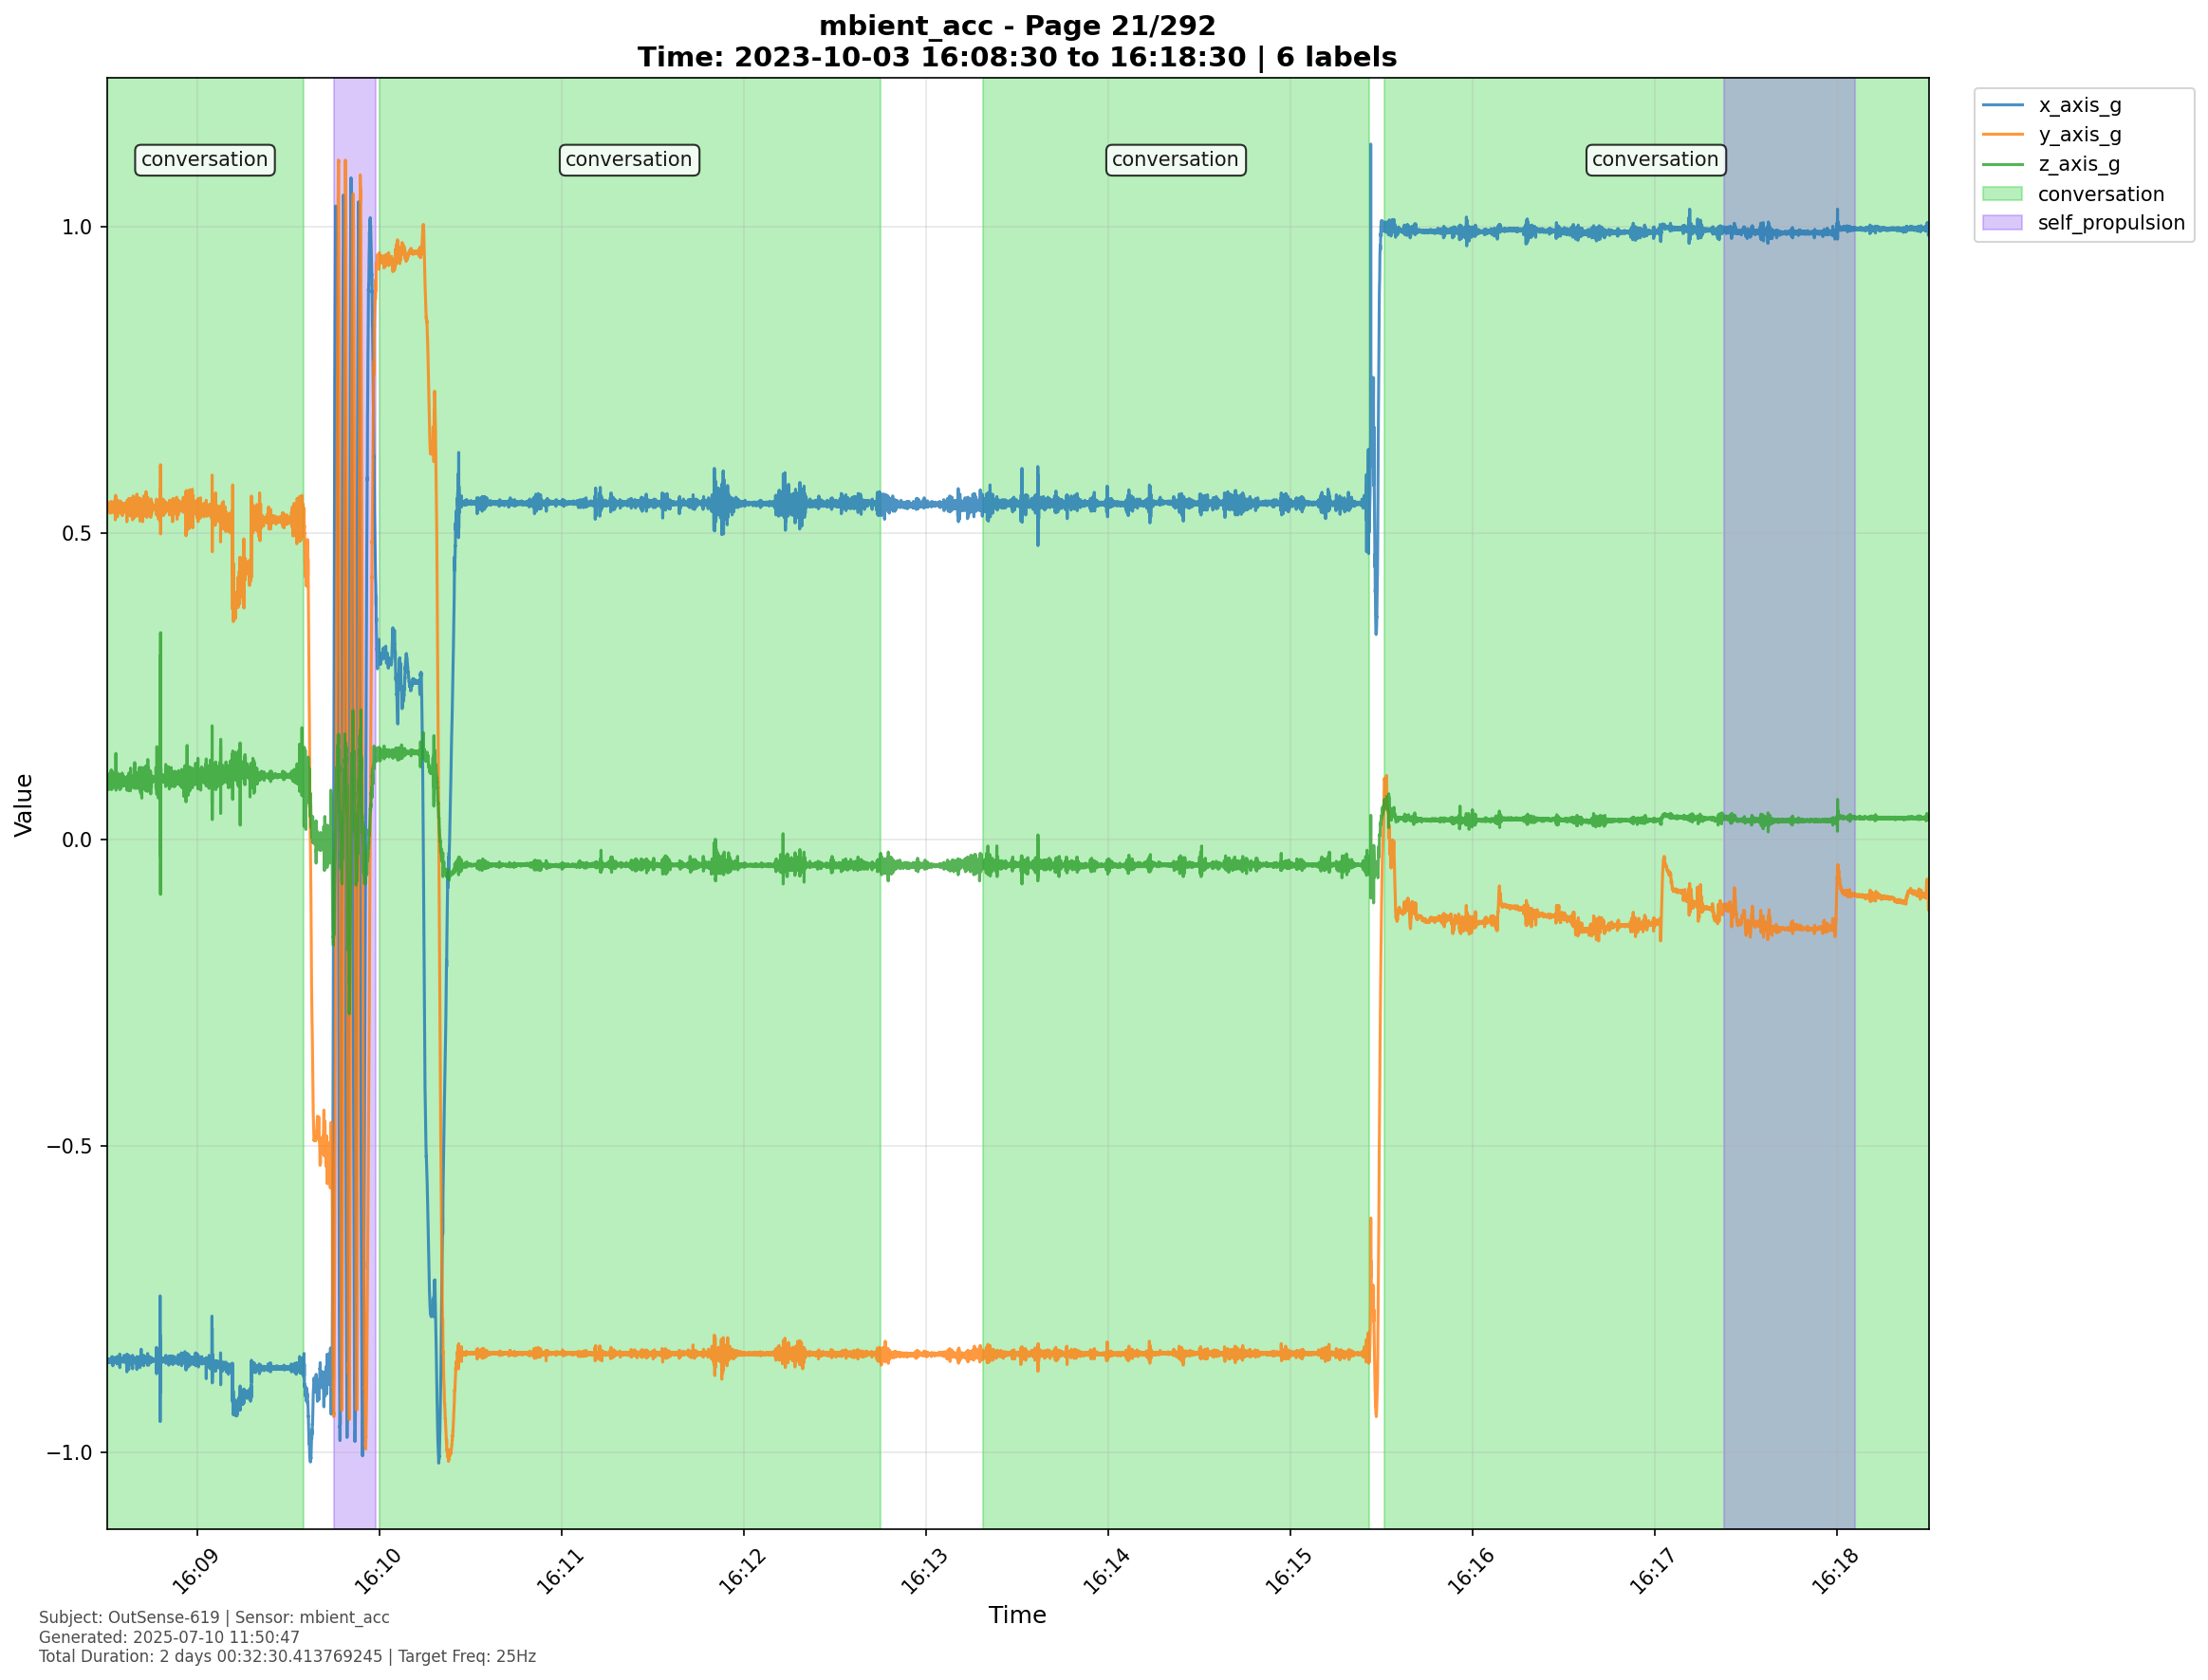

In [10]:
# Create comprehensive visualization export for final data quality check
import matplotlib.backends.backend_pdf as backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
import math

print("=== FINAL DATA VISUALIZATION EXPORT ===")
print("🎯 Creating comprehensive PDF plots for quality check before AI preprocessing")

# Create results directory structure
results_base_dir = os.path.join(project_root, 'stirnimann_r/results')
subject_results_dir = os.path.join(results_base_dir, SUBJECT_ID)
os.makedirs(subject_results_dir, exist_ok=True)

print(f"📂 Results directory: {subject_results_dir}")

# Configuration for plotting
MINUTES_PER_PAGE = 10  # 10 minutes per page
PAGE_WIDTH = 16       # Landscape format
PAGE_HEIGHT = 12      # Landscape format
DPI = 150            # Good quality for PDFs

# Determine overall time range across all sensors
print("\n📊 Determining overall time range...")
all_start_times = []
all_end_times = []

for sensor_name, sensor_data in processed_sensors.items():
    all_start_times.append(sensor_data.index.min())
    all_end_times.append(sensor_data.index.max())

if all_start_times and all_end_times:
    overall_start = min(all_start_times)
    overall_end = max(all_end_times)
    total_duration = overall_end - overall_start
    
    print(f"⏱️ Overall time range: {overall_start} to {overall_end}")
    print(f"⏱️ Total duration: {total_duration}")
    
    # Calculate number of pages needed
    total_minutes = total_duration.total_seconds() / 60
    num_pages = math.ceil(total_minutes / MINUTES_PER_PAGE)
    
    print(f"📄 Will create {num_pages} pages ({MINUTES_PER_PAGE} minutes each)")
    
    # Prepare labels for the entire time range
    if len(valid_labels) > 0:
        # Filter labels to the overall time range
        full_range_labels = valid_labels[
            (valid_labels['Real_Start_Time'] <= overall_end) & 
            (valid_labels['Real_End_Time'] >= overall_start)
        ]
        print(f"🏷️ {len(full_range_labels)} labels in full time range")
    else:
        full_range_labels = pd.DataFrame()
    
    # Process each sensor
    for sensor_name, sensor_data in processed_sensors.items():
        print(f"\n--- Processing sensor: {sensor_name} ---")
        
        # Create sensor-specific directory
        sensor_dir = os.path.join(subject_results_dir, sensor_name.replace('/', '_').replace(' ', '_'))
        os.makedirs(sensor_dir, exist_ok=True)
        
        # Define PDF filename
        pdf_filename = f"{SUBJECT_ID}_{sensor_name.replace('/', '_').replace(' ', '_')}_complete_data.pdf"
        pdf_path = os.path.join(sensor_dir, pdf_filename)
        
        print(f"📄 Creating PDF: {pdf_path}")
        
        # Get numeric columns for this sensor
        numeric_cols = sensor_data.select_dtypes(include=[np.number]).columns
        print(f"📈 Plotting {len(numeric_cols)} channels: {list(numeric_cols)}")
        
        # Create PDF with multiple pages
        with PdfPages(pdf_path) as pdf:
            for page_num in range(num_pages):
                print(f"  📄 Creating page {page_num + 1}/{num_pages}...")
                
                # Calculate time window for this page
                page_start = overall_start + pd.Timedelta(minutes=page_num * MINUTES_PER_PAGE)
                page_end = overall_start + pd.Timedelta(minutes=(page_num + 1) * MINUTES_PER_PAGE)
                
                # Don't go beyond the actual data range
                page_end = min(page_end, overall_end)
                
                # Filter sensor data for this page
                page_mask = (sensor_data.index >= page_start) & (sensor_data.index <= page_end)
                page_data = sensor_data[page_mask]
                
                # Filter labels for this page
                if len(full_range_labels) > 0:
                    page_labels = full_range_labels[
                        (full_range_labels['Real_Start_Time'] <= page_end) & 
                        (full_range_labels['Real_End_Time'] >= page_start)
                    ]
                else:
                    page_labels = pd.DataFrame()
                
                # Create figure
                fig, ax = plt.subplots(1, 1, figsize=(PAGE_WIDTH, PAGE_HEIGHT), dpi=DPI)
                
                # Plot sensor data
                if not page_data.empty and len(numeric_cols) > 0:
                    for col in numeric_cols:
                        ax.plot(page_data.index, page_data[col], 
                               label=col, alpha=0.8, linewidth=1.5)
                    
                    # Get y-axis limits for label positioning
                    y_min, y_max = ax.get_ylim()
                    y_range = y_max - y_min
                    
                    # Add label shading
                    if len(page_labels) > 0:
                        label_count = {}
                        for _, label_row in page_labels.iterrows():
                            label_name = label_row['Label']
                            start_time = max(label_row['Real_Start_Time'], page_start)
                            end_time = min(label_row['Real_End_Time'], page_end)
                            
                            if start_time < end_time:  # Valid time range
                                color = label_colors.get(label_name, 'gray')
                                
                                # Count occurrences for legend
                                if label_name not in label_count:
                                    label_count[label_name] = 0
                                label_count[label_name] += 1
                                
                                # Add shaded region
                                ax.axvspan(start_time, end_time, 
                                         alpha=0.3, 
                                         color=color,
                                         label=f'{label_name}' if label_count[label_name] == 1 else "",
                                         zorder=0)  # Behind the data
                                
                                # Add label text for longer labels
                                duration = end_time - start_time
                                if duration > pd.Timedelta(minutes=1):  # Only show text for labels > 1 minute
                                    mid_time = start_time + (end_time - start_time) / 2
                                    y_pos = y_max - y_range * 0.05
                                    
                                    ax.text(mid_time, y_pos, label_name, 
                                           ha='center', va='top', rotation=0,
                                           fontsize=10, alpha=0.9,
                                           bbox=dict(boxstyle='round,pad=0.3', 
                                                   facecolor='white', alpha=0.8))
                    
                    # Add sync event markers if in range
                    if page_start <= sync_start_time <= page_end:
                        ax.axvline(sync_start_time, color='red', linestyle='--', 
                                 linewidth=3, alpha=0.9, label='🎯 Sync Start')
                    
                    if page_start <= sync_end_time <= page_end:
                        ax.axvline(sync_end_time, color='darkred', linestyle='--', 
                                 linewidth=3, alpha=0.9, label='🎯 Sync End')
                    
                else:
                    # No data on this page
                    ax.text(0.5, 0.5, f'No {sensor_name} data in this time window', 
                           ha='center', va='center', transform=ax.transAxes,
                           fontsize=16, alpha=0.7)
                
                # Set time axis limits to exactly match the page window
                ax.set_xlim(page_start, page_end)
                
                # Formatting
                page_title = f'{sensor_name} - Page {page_num + 1}/{num_pages}\n'
                page_title += f'Time: {page_start.strftime("%Y-%m-%d %H:%M:%S")} to {page_end.strftime("%H:%M:%S")}'
                if len(page_labels) > 0:
                    page_title += f' | {len(page_labels)} labels'
                
                ax.set_title(page_title, fontsize=14, fontweight='bold')
                ax.set_xlabel('Time', fontsize=12)
                ax.set_ylabel('Value', fontsize=12)
                ax.grid(True, alpha=0.3)
                
                # Format time axis
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=max(1, MINUTES_PER_PAGE//10)))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
                
                # Legend (only if not too many items)
                handles, labels = ax.get_legend_handles_labels()
                if len(handles) <= 20:  # Reasonable number for legend
                    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
                
                # Add metadata text
                metadata_text = f'Subject: {SUBJECT_ID} | Sensor: {sensor_name}\n'
                metadata_text += f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n'
                metadata_text += f'Total Duration: {total_duration} | Target Freq: {TARGET_FREQUENCY}Hz'
                
                fig.text(0.02, 0.02, metadata_text, fontsize=8, alpha=0.7,
                        verticalalignment='bottom')
                
                plt.tight_layout()
                plt.subplots_adjust(right=0.85, bottom=0.1)
                
                # Save page to PDF
                pdf.savefig(fig, dpi=DPI, bbox_inches='tight')
                plt.close(fig)
        
        print(f"✅ PDF saved: {pdf_path}")
        print(f"   📄 {num_pages} pages, {MINUTES_PER_PAGE} minutes each")
        if len(numeric_cols) > 0:
            sensor_duration = sensor_data.index.max() - sensor_data.index.min()
            print(f"   ⏱️ Sensor duration: {sensor_duration}")
            print(f"   📊 {len(sensor_data)} samples, {len(numeric_cols)} channels")
    
    # Create summary report
    print(f"\n📋 Creating summary report...")
    summary_path = os.path.join(subject_results_dir, f"{SUBJECT_ID}_data_summary.txt")
    
    with open(summary_path, 'w') as f:
        f.write(f"DATA VISUALIZATION SUMMARY REPORT\n")
        f.write(f"=================================\n\n")
        f.write(f"Subject: {SUBJECT_ID}\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Project Root: {project_root}\n\n")
        
        f.write(f"TIME RANGE:\n")
        f.write(f"  Overall Start: {overall_start}\n")
        f.write(f"  Overall End: {overall_end}\n")
        f.write(f"  Total Duration: {total_duration}\n")
        f.write(f"  Pages Generated: {num_pages} ({MINUTES_PER_PAGE} minutes each)\n\n")
        
        f.write(f"SYNC EVENTS:\n")
        f.write(f"  Sync Start: {sync_start_time}\n")
        f.write(f"  Sync End: {sync_end_time}\n")
        f.write(f"  Sync Duration: {sync_end_time - sync_start_time}\n\n")
        
        f.write(f"SENSORS PROCESSED ({len(processed_sensors)}):\n")
        for sensor_name, sensor_data in processed_sensors.items():
            numeric_cols = sensor_data.select_dtypes(include=[np.number]).columns
            sensor_duration = sensor_data.index.max() - sensor_data.index.min()
            f.write(f"  📈 {sensor_name}:\n")
            f.write(f"    Samples: {len(sensor_data)}\n")
            f.write(f"    Duration: {sensor_duration}\n")
            f.write(f"    Channels: {len(numeric_cols)} {list(numeric_cols)}\n")
            f.write(f"    Time Range: {sensor_data.index.min()} to {sensor_data.index.max()}\n")
            f.write(f"    PDF: {sensor_name.replace('/', '_').replace(' ', '_')}_complete_data.pdf\n\n")
        
        if len(full_range_labels) > 0:
            f.write(f"LABELS ({len(full_range_labels)}):\n")
            label_summary = full_range_labels['Label'].value_counts()
            for label, count in label_summary.items():
                f.write(f"  🏷️ {label}: {count} instances\n")
            f.write(f"\n  Label Time Range: {full_range_labels['Real_Start_Time'].min()} to {full_range_labels['Real_End_Time'].max()}\n")
        else:
            f.write(f"LABELS: No labels available\n")
        
        f.write(f"\nCONFIGURATION:\n")
        f.write(f"  Target Frequency: {TARGET_FREQUENCY}Hz\n")
        f.write(f"  Minutes per Page: {MINUTES_PER_PAGE}\n")
        f.write(f"  Page Format: {PAGE_WIDTH}x{PAGE_HEIGHT} inches (landscape)\n")
        f.write(f"  DPI: {DPI}\n")
        
        # Time corrections applied
        f.write(f"\nTIME CORRECTIONS APPLIED:\n")
        subject_correction_params = sync_params.get(SUBJECT_ID, {})
        for sensor_name in processed_sensors.keys():
            # Find original sensor name
            original_sensor_name = sensor_name
            for orig_name in raw_data_parsing_config.keys():
                if orig_name in sensor_name:
                    original_sensor_name = orig_name
                    break
            
            sensor_corr_params = subject_correction_params.get(original_sensor_name, {})
            shift_applied = sensor_corr_params.get('shift', 0)
            unit = sensor_corr_params.get('unit', 's')
            
            f.write(f"  {sensor_name}: {shift_applied}{unit} shift")
            
            # Check for drift correction
            drift_params = sensor_corr_params.get('drift')
            if drift_params and all(k in drift_params for k in ['t0', 't1', 'drift_secs']):
                f.write(f", {drift_params['drift_secs']}s drift correction")
            f.write(f"\n")
    
    print(f"✅ Summary report saved: {summary_path}")
    
    print(f"\n🎯 FINAL DATA VISUALIZATION COMPLETE!")
    print(f"📂 Results directory: {subject_results_dir}")
    print(f"📄 PDFs created: {len(processed_sensors)} (one per sensor)")
    print(f"📋 Pages per PDF: {num_pages} ({MINUTES_PER_PAGE} minutes each)")
    print(f"⏱️ Total time span: {total_duration}")
    print(f"🏷️ Labels included: {len(full_range_labels)}")
    print(f"\n✅ Ready for AI model preprocessing!")
    print(f"\n💡 Use these PDFs to:")
    print(f"  • Verify data quality across all sensors")
    print(f"  • Check time synchronization accuracy")
    print(f"  • Validate label alignment with sensor data")
    print(f"  • Identify any remaining artifacts or issues")
    print(f"  • Confirm preprocessing parameters")

else:
    print("❌ No sensor data available for visualization")
    
print(f"\n📁 Results structure:")
print(f"  {subject_results_dir}/")
for sensor_name in processed_sensors.keys():
    clean_name = sensor_name.replace('/', '_').replace(' ', '_')
    print(f"  ├── {clean_name}/")
    print(f"  │   └── {SUBJECT_ID}_{clean_name}_complete_data.pdf")
print(f"  └── {SUBJECT_ID}_data_summary.txt")

## 8. Combined Data Table Creation

**Purpose**: Create a single synchronized table combining all sensor data with labels using a shared timestamp axis.

**Features**:
- Unified timestamp axis across all sensors
- All sensor channels as separate columns
- Label column indicating activity at each timestamp
- Empty label cells when no activity is present
- Saved as PKL file for efficient loading in AI preprocessing
- Perfect synchronization for machine learning workflows

In [12]:
# Create combined synchronized data table with all sensors and labels
import pickle

print("=== COMBINED DATA TABLE CREATION ===")
print("🔄 Creating unified table with synchronized timestamps, all sensors, and labels")

if not processed_sensors:
    print("❌ No processed sensor data available")
else:
    print(f"📊 Processing {len(processed_sensors)} sensors...")
    
    # Step 1: Determine the longest time range across all sensors
    print("\n📅 Step 1: Determining longest time range...")
    
    all_start_times = []
    all_end_times = []
    
    for sensor_name, sensor_data in processed_sensors.items():
        all_start_times.append(sensor_data.index.min())
        all_end_times.append(sensor_data.index.max())
        print(f"  📈 {sensor_name}: {sensor_data.index.min()} to {sensor_data.index.max()}")
    
    # Use the union of all sensor time ranges (longest possible range)
    common_start = min(all_start_times)  # Earliest start time
    common_end = max(all_end_times)      # Latest end time
    
    print(f"\n⏱️ Longest time range (union of all sensors):")
    print(f"  Start: {common_start}")
    print(f"  End: {common_end}")
    print(f"  Duration: {common_end - common_start}")
    print(f"  ℹ️ Sensors not covering full range will have NaN values in gaps")
    
    if common_start >= common_end:
        print("❌ Invalid time range found!")
    else:
        # Step 2: Create unified timestamp index
        print(f"\n⚙️ Step 2: Creating unified timestamp index at {TARGET_FREQUENCY}Hz...")
        
        # Create regular timestamp index at target frequency
        total_seconds = (common_end - common_start).total_seconds()
        num_samples = int(total_seconds * TARGET_FREQUENCY)
        
        # Create timestamp index
        timestamp_index = pd.date_range(
            start=common_start,
            end=common_end,
            periods=num_samples
        )
        
        print(f"  📊 Created {len(timestamp_index)} timestamps")
        print(f"  🕐 Frequency: {TARGET_FREQUENCY}Hz")
        print(f"  📏 Interval: {timestamp_index[1] - timestamp_index[0]}")
        
        # Step 3: Resample and align all sensor data
        print(f"\n🔄 Step 3: Resampling and aligning sensor data...")
        
        combined_data = pd.DataFrame(index=timestamp_index)
        sensor_stats = {}
        
        for sensor_name, sensor_data in processed_sensors.items():
            print(f"  📈 Processing {sensor_name}...")
            
            # Get numeric columns
            numeric_cols = sensor_data.select_dtypes(include=[np.number]).columns
            print(f"    📊 {len(numeric_cols)} numeric columns")
            
            # Check coverage within the longest time range
            sensor_start = sensor_data.index.min()
            sensor_end = sensor_data.index.max()
            coverage_start = max(sensor_start, common_start)
            coverage_end = min(sensor_end, common_end)
            
            print(f"    📅 Sensor range: {sensor_start} to {sensor_end}")
            print(f"    🎯 Coverage in full range: {coverage_start} to {coverage_end}")
            
            # Process the sensor data (no filtering to common range)
            sensor_data_clean = sensor_data.copy()
            
            # First ensure monotonic index (remove any duplicates)
            sensor_data_clean = sensor_data_clean[~sensor_data_clean.index.duplicated(keep='first')]
            sensor_data_clean = sensor_data_clean.sort_index()
            
            # Resample using linear interpolation
            resampled_data = sensor_data_clean[numeric_cols].resample(f'{1000//TARGET_FREQUENCY}ms').mean()
            
            # Interpolate to fill gaps within sensor's own time range
            resampled_data = resampled_data.interpolate(method='linear', limit=TARGET_FREQUENCY*2)
            
            # Align to our full timestamp index (this will create NaN for times outside sensor range)
            aligned_data = resampled_data.reindex(timestamp_index, method='nearest', tolerance=pd.Timedelta(f'{2000//TARGET_FREQUENCY}ms'))
            
            # Add sensor prefix to column names to avoid conflicts
            sensor_prefix = sensor_name.replace(' ', '_').replace('/', '_')
            aligned_data.columns = [f"{sensor_prefix}_{col}" for col in aligned_data.columns]
            
            # Add to combined dataframe
            for col in aligned_data.columns:
                combined_data[col] = aligned_data[col]
            
            # Statistics
            valid_samples = aligned_data.notna().sum().sum()
            total_samples = len(aligned_data) * len(aligned_data.columns)
            coverage = valid_samples / total_samples * 100 if total_samples > 0 else 0
            
            # Calculate time coverage
            time_coverage_start = max(sensor_start, common_start)
            time_coverage_end = min(sensor_end, common_end)
            time_coverage_duration = time_coverage_end - time_coverage_start
            full_duration = common_end - common_start
            time_coverage_percent = (time_coverage_duration.total_seconds() / full_duration.total_seconds()) * 100
            
            sensor_stats[sensor_name] = {
                'original_samples': len(sensor_data_clean),
                'resampled_samples': len(aligned_data),
                'channels': len(aligned_data.columns),
                'coverage_percent': coverage,
                'missing_samples': total_samples - valid_samples,
                'time_coverage_percent': time_coverage_percent,
                'sensor_start': sensor_start.isoformat(),
                'sensor_end': sensor_end.isoformat(),
                'gaps_filled_with_nan': total_samples - valid_samples
            }
            
            print(f"    ✅ {len(aligned_data.columns)} channels added")
            print(f"    📊 Data coverage: {coverage:.1f}% ({valid_samples}/{total_samples} samples)")
            print(f"    ⏰ Time coverage: {time_coverage_percent:.1f}% of full range")
            if total_samples - valid_samples > 0:
                print(f"    🕳️ {total_samples - valid_samples} samples filled with NaN (outside sensor range)")
        
        # Step 4: Add corrected label information
        print(f"\n🏷️ Step 4: Adding corrected label information...")
        
        # Initialize label column
        combined_data['Label'] = ''
        
        # Use the globally corrected labels if available, otherwise use original
        labels_to_use = corrected_labels_global if len(corrected_labels_global) > 0 else valid_labels
        
        if len(labels_to_use) > 0:
            print(f"  📋 Processing {len(labels_to_use)} corrected labels...")
            
            # Show correction summary
            if len(corrected_labels_global) > 0 and current_correction_log:
                print(f"  🔧 Label corrections applied:")
                if current_correction_log.get('manual_offset_applied', 0) != 0:
                    print(f"    Manual offset: {current_correction_log['manual_offset_applied']}s")
                if current_correction_log.get('linear_drift_applied', False):
                    print(f"    Linear drift correction: enabled")
            
            # Filter labels to longest time range
            common_labels = labels_to_use[
                (labels_to_use['Real_Start_Time'] <= common_end) & 
                (labels_to_use['Real_End_Time'] >= common_start)
            ].copy()
            
            print(f"  🎯 {len(common_labels)} corrected labels in longest time range")
            
            # For each label, mark the corresponding timestamps
            label_count = 0
            overlap_count = 0
            
            for _, label_row in common_labels.iterrows():
                start_time = max(label_row['Real_Start_Time'], common_start)
                end_time = min(label_row['Real_End_Time'], common_end)
                label_name = label_row['Label']
                
                if start_time < end_time:
                    # Find timestamps within this label period
                    mask = (combined_data.index >= start_time) & (combined_data.index <= end_time)
                    matching_timestamps = combined_data.index[mask]
                    
                    if len(matching_timestamps) > 0:
                        # Check for overlapping labels
                        existing_labels = combined_data.loc[mask, 'Label']
                        overlaps = existing_labels[existing_labels != '']
                        
                        if len(overlaps) > 0:
                            overlap_count += len(overlaps)
                            # For overlapping labels, create combined label
                            for idx in matching_timestamps:
                                existing = combined_data.loc[idx, 'Label']
                                if existing == '':
                                    combined_data.loc[idx, 'Label'] = label_name
                                elif label_name not in existing:
                                    combined_data.loc[idx, 'Label'] = f"{existing}+{label_name}"
                        else:
                            # No overlap, assign label directly
                            combined_data.loc[mask, 'Label'] = label_name
                        
                        label_count += len(matching_timestamps)
            
            print(f"  ✅ {label_count} timestamps labeled")
            print(f"  ⚠️ {overlap_count} overlapping label instances handled")
            
            # Label statistics
            labeled_count = (combined_data['Label'] != '').sum()
            total_count = len(combined_data)
            label_coverage = labeled_count / total_count * 100
            
            print(f"  📊 Label coverage: {label_coverage:.1f}% ({labeled_count}/{total_count} timestamps)")
            
            # Show label distribution
            label_dist = combined_data['Label'].value_counts()
            non_empty_labels = label_dist[label_dist.index != '']
            
            print(f"  📋 Label distribution (top 10):")
            for label, count in non_empty_labels.head(10).items():
                duration_seconds = count / TARGET_FREQUENCY
                print(f"    🏷️ {label}: {count} samples ({duration_seconds:.1f}s)")
            
            if len(non_empty_labels) > 10:
                print(f"    ... and {len(non_empty_labels) - 10} more labels")
        
        else:
            print("  ⚠️ No labels available - Label column will remain empty")
        
        # Step 5: Data quality summary
        print(f"\n📊 Step 5: Data quality summary...")
        
        total_sensor_cols = len([col for col in combined_data.columns if col != 'Label'])
        total_samples = len(combined_data)
        
        print(f"  📋 Final combined table:")
        print(f"    Timestamps: {total_samples}")
        print(f"    Sensor columns: {total_sensor_cols}")
        print(f"    Label column: 1")
        print(f"    Total columns: {len(combined_data.columns)}")
        print(f"    Time range: {combined_data.index.min()} to {combined_data.index.max()}")
        print(f"    Duration: {combined_data.index.max() - combined_data.index.min()}")
        print(f"    Frequency: {TARGET_FREQUENCY}Hz")
        
        # Missing data analysis
        missing_data = combined_data.select_dtypes(include=[np.number]).isnull().sum()
        if missing_data.sum() > 0:
            print(f"  🕳️ Missing data summary (NaN values where sensors don't cover full range):")
            for col, missing_count in missing_data[missing_data > 0].items():
                missing_pct = missing_count / total_samples * 100
                print(f"    {col}: {missing_count} samples ({missing_pct:.1f}%)")
        else:
            print(f"  ✅ No missing data in sensor columns")
        
        # Step 6: Save combined data
        print(f"\n💾 Step 6: Saving combined data...")
        
        # Define save path
        pkl_filename = f"{SUBJECT_ID}_combined_data.pkl"
        pkl_path = os.path.join(subject_results_dir, pkl_filename)
        
        # Save as pickle file
        try:
            with open(pkl_path, 'wb') as f:
                pickle.dump(combined_data, f, protocol=pickle.HIGHEST_PROTOCOL)
            
            print(f"✅ Combined data saved: {pkl_path}")
            
            # File size info
            file_size = os.path.getsize(pkl_path)
            file_size_mb = file_size / (1024 * 1024)
            print(f"  📁 File size: {file_size_mb:.1f} MB")
            
            # Save metadata
            metadata = {
                'subject_id': SUBJECT_ID,
                'creation_time': datetime.now().isoformat(),
                'time_range': {
                    'start': combined_data.index.min().isoformat(),
                    'end': combined_data.index.max().isoformat(),
                    'duration_seconds': (combined_data.index.max() - combined_data.index.min()).total_seconds(),
                    'range_type': 'longest_union'  # Indicates this uses the longest range
                },
                'sampling': {
                    'target_frequency_hz': TARGET_FREQUENCY,
                    'total_samples': total_samples,
                    'actual_frequency_hz': total_samples / (combined_data.index.max() - combined_data.index.min()).total_seconds()
                },
                'sensors': sensor_stats,
                'columns': {
                    'total': len(combined_data.columns),
                    'sensor_channels': total_sensor_cols,
                    'label_column': 1,
                    'column_names': list(combined_data.columns)
                },
                'labels': {
                    'total_labels_available': len(valid_labels),
                    'labels_in_timerange': len(common_labels) if len(valid_labels) > 0 else 0,
                    'labeled_timestamps': labeled_count if len(valid_labels) > 0 else 0,
                    'label_coverage_percent': label_coverage if len(valid_labels) > 0 else 0,
                    'unique_labels': list(non_empty_labels.index) if len(valid_labels) > 0 else []
                },
                'data_quality': {
                    'missing_values': missing_data.to_dict(),
                    'coverage_by_sensor': {name: stats['coverage_percent'] for name, stats in sensor_stats.items()},
                    'time_coverage_by_sensor': {name: stats['time_coverage_percent'] for name, stats in sensor_stats.items()}
                }
            }
            
            # Save metadata as JSON
            metadata_path = os.path.join(subject_results_dir, f"{SUBJECT_ID}_combined_data_metadata.json")
            import json
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2, default=str)
            
            print(f"✅ Metadata saved: {metadata_path}")
            
        except Exception as e:
            print(f"❌ Error saving combined data: {e}")
            import traceback
            traceback.print_exc()
        
        # Step 7: Verification and summary
        print(f"\n✅ COMBINED DATA TABLE COMPLETE!")
        print(f"📂 Saved to: {pkl_path}")
        print(f"📊 Shape: {combined_data.shape}")
        print(f"⏱️ Time span: {combined_data.index.max() - combined_data.index.min()}")
        print(f"🎯 Frequency: {TARGET_FREQUENCY}Hz")
        print(f"📈 Sensors: {len(processed_sensors)}")
        print(f"🏷️ Labels: {'Yes' if len(valid_labels) > 0 else 'No'}")
        print(f"🕳️ NaN handling: Gaps filled for sensors not covering full time range")
        
        print(f"\n💡 Usage for AI preprocessing:")
        print(f"  import pickle")
        print(f"  with open('{pkl_path}', 'rb') as f:")
        print(f"      data = pickle.load(f)")
        print(f"  # data is a pandas DataFrame with:")
        print(f"  # - Index: synchronized timestamps (longest range)")
        print(f"  # - Columns: all sensor channels + 'Label'")
        print(f"  # - NaN values where sensors don't cover full range")
        print(f"  # - Ready for feature extraction and ML")
        
        print(f"\n📋 Column structure:")
        sensor_cols = [col for col in combined_data.columns if col != 'Label']
        print(f"  Sensor columns ({len(sensor_cols)}):")
        for sensor_name in processed_sensors.keys():
            sensor_prefix = sensor_name.replace(' ', '_').replace('/', '_')
            matching_cols = [col for col in sensor_cols if col.startswith(sensor_prefix)]
            time_cov = sensor_stats[sensor_name]['time_coverage_percent']
            print(f"    📈 {sensor_name}: {len(matching_cols)} channels (covers {time_cov:.1f}% of time range)")
        print(f"  🏷️ Label column: 'Label' (activity annotations)")
        
        # Show sample of the data
        print(f"\n👀 Sample data (first 5 rows):")
        print(combined_data.head())
        
        if len(valid_labels) > 0:
            # Show some labeled samples
            labeled_samples = combined_data[combined_data['Label'] != '']
            if len(labeled_samples) > 0:
                print(f"\n🏷️ Sample labeled data:")
                print(labeled_samples.head())

print(f"\n📁 Final results structure:")
print(f"  {subject_results_dir}/")
for sensor_name in processed_sensors.keys():
    clean_name = sensor_name.replace('/', '_').replace(' ', '_')
    print(f"  ├── {clean_name}/")
    print(f"  │   └── {SUBJECT_ID}_{clean_name}_complete_data.pdf")
print(f"  ├── {SUBJECT_ID}_combined_data.pkl")
print(f"  ├── {SUBJECT_ID}_combined_data_metadata.json")
print(f"  └── {SUBJECT_ID}_data_summary.txt")

=== COMBINED DATA TABLE CREATION ===
🔄 Creating unified table with synchronized timestamps, all sensors, and labels
📊 Processing 8 sensors...

📅 Step 1: Determining longest time range...
  📈 corsano_wrist: 2023-10-03 12:50:25 to 2023-10-05 13:10:33.967999935
  📈 cosinuss_ear: 2023-10-03 12:48:30.302000046 to 2023-10-04 17:51:39.632999897
  📈 mbient_acc: 2023-10-03 12:59:02.941925049 to 2023-10-05 13:20:49.678373337
  📈 mbient_gyro: 2023-10-03 12:59:09.867031097 to 2023-10-05 13:21:00.715769291
  📈 vivalnk_acc: 2023-10-03 13:35:44.371999979 to 2023-10-05 13:17:38.171999931
  📈 sensomative_bottom: 2023-10-03 12:56:17.197129011 to 2023-10-05 13:04:33.311639547
  📈 sensomative_back: 2023-10-03 12:56:32.613219023 to 2023-10-05 13:04:29.798619032
  📈 corsano_bioz: 2023-10-03 12:50:25.964224815 to 2023-10-05 13:10:30.985158682

⏱️ Longest time range (union of all sensors):
  Start: 2023-10-03 12:48:30.302000046
  End: 2023-10-05 13:21:00.715769291
  Duration: 2 days 00:32:30.413769245
  ℹ️ Se